In [1]:
import json
import lzma
import numpy as np
import os
import pandas as pd
import regex as re
import tarfile
import zipfile
from io import StringIO
from os import listdir as ls
from pandas import DataFrame as df
from tqdm import tqdm
from typing import Union
from unidecode import unidecode
from os.path import basename as bname
from os.path import dirname as dname
from os.path import expanduser as xpu
from os.path import join as pjoin
from os.path import normcase as nc
from tarfile import TarFile

import sniffbytes as snif
from sniffbytes import flatten
from sniffbytes import get_bytes
from sniffbytes import loadimages
from sniffbytes import loadfiles
from sniffbytes import filter_lst_inc
from sniffbytes import get_bencod

from fetch_cimaq import get_qc_list
from scanzip import getnametuple

d0319 = xpu("~/../../data/simexp/datasets/cimaq_03-19")
d0919 = xpu("~/../../data/simexp/datasets/cimaq_20190901")
# s0319 = [pd.concat([loadimages(loadfiles(loadimages(pjoin(adir, sub)))) for sub in
#          filter_lst_inc(["sub"], ls(adir))])
#          for adir in [d0319, d0919]]


In [72]:
cimaq_dir01 = "~/../../data/simexp/datasets/cimaq_03-19"
cimaq_dir02 = "~/../../data/simexp/datasets/cimaq_20190901"


colnames = ['pscid', 'dccid', 'visit', 'archive', 'seriesuid', 'echotime', 'qc']

def get_qc_list() -> list:
    return pd.read_csv(pjoin(os.getcwd(),
                             "sub_list_TaskQC.csv"),
                       header = None).astype(str).values.tolist()[0][1:]

def load_series_uid() -> pd.DataFrame:
    qcok = get_qc_list()
    return df((row[1] for row in tqdm(pd.read_csv(
        pjoin(os.getcwd(), "seriesUID_qc.csv")).iterrows(),
                                      desc = "loading")
              if str(row[1].CandID) in qcok))

def get_cimaq_ids() -> list:
    return df((itm.split("_") + [itm] for itm in
               pd.Series(("_".join((str(itm) for itm in
                                    row[1].values))
                          for row in
                          load_series_uid().iloc[:, :2].iterrows())).unique()),
              columns = ["pscid", "dccid", "subid"])

def load_subjects(src_dir: Union[str, os.PathLike]) -> list:
    return df(((sub.split("-")[1],
                loadimages(pjoin(xpu(src_dir), sub)))
                 for sub in tqdm(filter_lst_inc(get_qc_list() + ["sub"],
                                             ls(xpu(src_dir))),
                            desc = 'loading subject files')))
cimaq_ids = get_cimaq_ids()
# cimaq_ids['allfiles'] = [[]]
# "619278" in "8192087_619278"
cimaq_ids

loading: 3375it [00:00, 5129.64it/s]


pscid   dccid           subid
0   8192087  619278  8192087_619278
1   5522727  267168  5522727_267168
2   4835330  677561  4835330_677561
3   8330218  413474  8330218_413474
4   3431566  164965  3431566_164965
..      ...     ...             ...
89  7485585  386333  7485585_386333
90  8758136  886007  8758136_886007
91  8875385  437101  8875385_437101
92  3123186  920577  3123186_920577
93  3750063  956049  3750063_956049

[94 rows x 3 columns]

In [6]:
from fetch_cimaq import xtrct_cimaq
# test = xtrct_cimaq(d0319)
test2 = xtrct_cimaq(d0919)


scanning archive: 0it [00:00, ?it/s]


ValueError: No objects to concatenate

In [7]:
test

filename compress_type  \
0    3025432_658178_tache_irm_onset-event-encoding_...       deflate   
1    3025432_658178_tache_irm_output-responses-enco...       deflate   
2    3025432_658178_tache_irm_output_retrieval_cima...       deflate   
3    3123186_920577_tache_irm_onset-event-encoding_...       deflate   
4    3123186_920577_tache_irm_output-responses-enco...       deflate   
..                                                 ...           ...   
277  9494076_630120_tache_irm_output-responses-enco...       deflate   
278  9494076_630120_tache_irm_output_retrieval_cima...       deflate   
279  9929164_197192_tache_irm_onset-event-encoding_...       deflate   
280  9929164_197192_tache_irm_output-responses-enco...       deflate   
281  9929164_197192_tache_irm_output_retrieval_cima...       deflate   

       filemode external_attr file_size compress_size  \
0    -rwxrwxrwx        0x4000     21511          3011   
1    -rwxrwxrwx        0x4000      3557          1206   
2    -rwxrwxrwx        0x4000      5816          2174   
3           NaN          0x20     21512          2915   
4           NaN          0x20      3125           873   
..          ...           ...       ...           ...   
277         NaN          0x20      3521          1099   
278         NaN          0x20      5843          2172   
279  -rwxrwxrwx        0x4000     21511          2780   
280  -rwxrwxrwx        0x4000      3125           873   
281  -rwxrwxrwx        0x4000      5876          2216   

                                             src_names  \
0    3025432_658178_Tache_IRM/Onset-Event-Encoding_...   
1    3025432_658178_Tache_IRM/Output-Responses-Enco...   
2    3025432_658178_Tache_IRM/Output_Retrieval_CIMA...   
3    3123186_920577_Tache_IRM/Onset-Event-Encoding_...   
4    3123186_920577_Tache_IRM/Output-Responses-Enco...   
..                                                 ...   
277  9494076_630120_Tache_IRM/Output-Responses-Enco...   
278  9494076_630120_Tache_IRM/Output_Retrieval_CIMA...   
279  9929164_197192_Tache_IRM/Onset-Event-Encoding_...   
280  9929164_197192_Tache_IRM/Output-Responses-Enco...   
281  9929164_197192_Tache_IRM/Output_Retrieval_CIMA...   

                                               bsheets  
0    b'1             ctl           ctl0            ...  
1    b'trialnumber\tcategory\ttrialcode\toldnumber\...  
2    b'category\tstim\toldnumber\trecognition_acc\t...  
3    b'1             enc           enc00           ...  
4    b'trialnumber\tcategory\ttrialcode\toldnumber\...  
..                                                 ...  
277  b'trialnumber\tcategory\ttrialcode\toldnumber\...  
278  b'category\tstim\toldnumber\trecognition_acc\t...  
279  b'1             ctl           ctl0            ...  
280  b'trialnumber\tcategory\ttrialcode\toldnumber\...  
281  b'category\tstim\toldnumber\trecognition_acc\t...  

[282 rows x 8 columns]

In [24]:
uzeprimes = loadfiles(loadimages(pjoin(os.getcwd(), 'newdevs/cimaq_uzeprimes')))
events = loadfiles(loadimages(pjoin(os.getcwd(), 'newtest/events')))
behavioural = loadfiles(loadimages(pjoin(os.getcwd(), 'newtest/behavioural')))
display(events, behavioural, uzeprimes)

filename   ext  parent  \
0   sub-_3025432_658178_run-01_task-encoding_events  .tsv  events   
1   sub-_3123186_920577_run-01_task-encoding_events  .tsv  events   
2   sub-_3163875_199801_run-01_task-encoding_events  .tsv  events   
3   sub-_3291977_748676_run-01_task-encoding_events  .tsv  events   
4   sub-_3400972_956130_run-01_task-encoding_events  .tsv  events   
..                                              ...   ...     ...   
89  sub-_9003010_785245_run-01_task-encoding_events  .tsv  events   
90  sub-_9249304_778749_run-01_task-encoding_events  .tsv  events   
91  sub-_9296157_955548_run-01_task-encoding_events  .tsv  events   
92  sub-_9494076_630120_run-01_task-encoding_events  .tsv  events   
93  sub-_9929164_197192_run-01_task-encoding_events  .tsv  events   

                                               fpaths  
0   /home/fnadeau/cimaq_memory/newtest/events/sub-...  
1   /home/fnadeau/cimaq_memory/newtest/events/sub-...  
2   /home/fnadeau/cimaq_memory/newtest/events/sub-...  
3   /home/fnadeau/cimaq_memory/newtest/events/sub-...  
4   /home/fnadeau/cimaq_memory/newtest/events/sub-...  
..                                                ...  
89  /home/fnadeau/cimaq_memory/newtest/events/sub-...  
90  /home/fnadeau/cimaq_memory/newtest/events/sub-...  
91  /home/fnadeau/cimaq_memory/newtest/events/sub-...  
92  /home/fnadeau/cimaq_memory/newtest/events/sub-...  
93  /home/fnadeau/cimaq_memory/newtest/events/sub-...  

[94 rows x 4 columns]

filename   ext       parent  \
0   sub-_3025432_658178_run-01_task-encoding_behav...  .tsv  behavioural   
1   sub-_3123186_920577_run-01_task-encoding_behav...  .tsv  behavioural   
2   sub-_3163875_199801_run-01_task-encoding_behav...  .tsv  behavioural   
3   sub-_3291977_748676_run-01_task-encoding_behav...  .tsv  behavioural   
4   sub-_3400972_956130_run-01_task-encoding_behav...  .tsv  behavioural   
..                                                ...   ...          ...   
89  sub-_9003010_785245_run-01_task-encoding_behav...  .tsv  behavioural   
90  sub-_9249304_778749_run-01_task-encoding_behav...  .tsv  behavioural   
91  sub-_9296157_955548_run-01_task-encoding_behav...  .tsv  behavioural   
92  sub-_9494076_630120_run-01_task-encoding_behav...  .tsv  behavioural   
93  sub-_9929164_197192_run-01_task-encoding_behav...  .tsv  behavioural   

                                               fpaths  
0   /home/fnadeau/cimaq_memory/newtest/behavioural...  
1   /home/fnadeau/cimaq_memory/newtest/behavioural...  
2   /home/fnadeau/cimaq_memory/newtest/behavioural...  
3   /home/fnadeau/cimaq_memory/newtest/behavioural...  
4   /home/fnadeau/cimaq_memory/newtest/behavioural...  
..                                                ...  
89  /home/fnadeau/cimaq_memory/newtest/behavioural...  
90  /home/fnadeau/cimaq_memory/newtest/behavioural...  
91  /home/fnadeau/cimaq_memory/newtest/behavioural...  
92  /home/fnadeau/cimaq_memory/newtest/behavioural...  
93  /home/fnadeau/cimaq_memory/newtest/behavioural...  

[94 rows x 4 columns]

filename   ext           parent  \
0   3025432_658178_tache_irm_3025432_658178  .pdf  cimaq_uzeprimes   
1   3291977_748676_tache_irm_3291977_748676  .pdf  cimaq_uzeprimes   
2   3400972_956130_tache_irm_3400972_956130  .pdf  cimaq_uzeprimes   
3   3420680_878354_tache_irm_3420680_878354  .pdf  cimaq_uzeprimes   
4     3589314_893978_tache_irm_debriefing_1  .pdf  cimaq_uzeprimes   
..                                      ...   ...              ...   
62  8980899_968913_tache_irm_8980899_968913  .pdf  cimaq_uzeprimes   
63  9003010_785245_tache_irm_9003010_785245  .pdf  cimaq_uzeprimes   
64  9249304_778749_tache_irm_9249304_778749  .pdf  cimaq_uzeprimes   
65  9296157_955548_tache_irm_9296157_955548  .pdf  cimaq_uzeprimes   
66  9929164_197192_tache_irm_9929164_197192  .pdf  cimaq_uzeprimes   

                                               fpaths  
0   /home/fnadeau/cimaq_memory/newdevs/cimaq_uzepr...  
1   /home/fnadeau/cimaq_memory/newdevs/cimaq_uzepr...  
2   /home/fnadeau/cimaq_memory/newdevs/cimaq_uzepr...  
3   /home/fnadeau/cimaq_memory/newdevs/cimaq_uzepr...  
4   /home/fnadeau/cimaq_memory/newdevs/cimaq_uzepr...  
..                                                ...  
62  /home/fnadeau/cimaq_memory/newdevs/cimaq_uzepr...  
63  /home/fnadeau/cimaq_memory/newdevs/cimaq_uzepr...  
64  /home/fnadeau/cimaq_memory/newdevs/cimaq_uzepr...  
65  /home/fnadeau/cimaq_memory/newdevs/cimaq_uzepr...  
66  /home/fnadeau/cimaq_memory/newdevs/cimaq_uzepr...  

[67 rows x 4 columns]

In [75]:
my_filter = [{"id": lzma.FILTER_LZMA2, "preset": 9 | lzma.PRESET_EXTREME}]
lzma_cmp = lzma.LZMACompressor(filters=my_filter)
inpt = get_bytes(events.fpaths[0])
test01xz = lzma_cmp.compress(inpt)
sizeof_fmt(len(inpt)), sizeof_fmt(len(test01xz))

('5.9KiB', '24.0B')

In [92]:
def unzip_obj(src_path):
    with gzip.open(src_path, 'rb') as f_in:
        uzobj = f_in.read()
    f_in.close()
    return uzobj
#         with open(os.path.splitext(src_path)[0], 'rb') as f_out:
#             uzobj = f_out.read()
#         f_out.close()
#     f_in.close()
#     return uzobj

#             shutil.copyfileobj(f_in, f_out)

In [164]:
import gzip
import lzma

subject = loadfiles(loadimages(xpu(pjoin(d0919, 'sub-4835330'))))
brainpath = subject.iloc[36].fpaths
brainpath


'/home/fnadeau/../../data/simexp/datasets/cimaq_20190901/sub-4835330/ses-V03/func/sub-4835330_ses-V03_task-memory_bold.nii.gz'

/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/plotting/displays.py:1751: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fraction * (x1 - x0), y1 - y0])
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nil

/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/plotting/displays.py:1751: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fraction * (x1 - x0), y1 - y0])
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/plotting/displays.py:1751: MatplotlibDeprecationWarning: Adding an axes using the same 

/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/plotting/displays.py:1751: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fraction * (x1 - x0), y1 - y0])
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/plotting/displays.py:1751: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future be

/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/plotting/displays.py:1751: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fraction * (x1 - x0), y1 - y0])
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/plotting/displays.py:1751: MatplotlibDeprecationWarning: Adding an axes using the same 

/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/plotting/displays.py:1751: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fraction * (x1 - x0), y1 - y0])
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/plotting/displays.py:1751: MatplotlibDeprecationWarning: Adding an axes using the same 

/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/plotting/displays.py:1751: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fraction * (x1 - x0), y1 - y0])
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/plotting/displays.py:1751: MatplotlibDeprecationWarning: Adding an axes using the same 

/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/plotting/displays.py:1751: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fraction * (x1 - x0), y1 - y0])
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/plotting/displays.py:1751: MatplotlibDeprecationWarning: Adding an axes using the same 

/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/plotting/displays.py:1751: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fraction * (x1 - x0), y1 - y0])
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/plotting/displays.py:1751: MatplotlibDeprecationWarning: Adding an axes using the same 

/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/plotting/displays.py:1751: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fraction * (x1 - x0), y1 - y0])
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/plotting/displays.py:1751: MatplotlibDeprecationWarning: Adding an axes using the same 

/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/plotting/displays.py:1751: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fraction * (x1 - x0), y1 - y0])
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/plotting/displays.py:1751: MatplotlibDeprecationWarning: Adding an axes using the same 

/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/plotting/displays.py:1751: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fraction * (x1 - x0), y1 - y0])
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/plotting/displays.py:1751: MatplotlibDeprecationWarning: Adding an axes using the same 

/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/plotting/displays.py:1751: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fraction * (x1 - x0), y1 - y0])
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/plotting/displays.py:1751: MatplotlibDeprecationWarning: Adding an axes using the same 

/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/plotting/displays.py:1751: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fraction * (x1 - x0), y1 - y0])
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/plotting/displays.py:1751: MatplotlibDeprecationWarning: Adding an axes using the same 

/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/plotting/displays.py:1751: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fraction * (x1 - x0), y1 - y0])
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/plotting/displays.py:1751: MatplotlibDeprecationWarning: Adding an axes using the same 

/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/plotting/displays.py:1751: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fraction * (x1 - x0), y1 - y0])
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/plotting/displays.py:1751: MatplotlibDeprecationWarning: Adding an axes using the same 

/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/plotting/displays.py:1751: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fraction * (x1 - x0), y1 - y0])
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/plotting/displays.py:1751: MatplotlibDeprecationWarning: Adding an axes using the same 

/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/plotting/displays.py:1751: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fraction * (x1 - x0), y1 - y0])
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/plotting/displays.py:1751: MatplotlibDeprecationWarning: Adding an axes using the same 

/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/plotting/displays.py:1751: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fraction * (x1 - x0), y1 - y0])
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/plotting/displays.py:1751: MatplotlibDeprecationWarning: Adding an axes using the same 

/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/plotting/displays.py:1751: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fraction * (x1 - x0), y1 - y0])
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/plotting/displays.py:1751: MatplotlibDeprecationWarning: Adding an axes using the same 

/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/plotting/displays.py:1751: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fraction * (x1 - x0), y1 - y0])
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/plotting/displays.py:1751: MatplotlibDeprecationWarning: Adding an axes using the same 

/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/plotting/displays.py:1751: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fraction * (x1 - x0), y1 - y0])
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/plotting/displays.py:1751: MatplotlibDeprecationWarning: Adding an axes using the same 

/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/plotting/displays.py:1751: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fraction * (x1 - x0), y1 - y0])
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/plotting/displays.py:1751: MatplotlibDeprecationWarning: Adding an axes using the same 

/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/plotting/displays.py:1751: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fraction * (x1 - x0), y1 - y0])
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/plotting/displays.py:1751: MatplotlibDeprecationWarning: Adding an axes using the same 

/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/plotting/displays.py:1751: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fraction * (x1 - x0), y1 - y0])
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/fnadeau/cimaqenv/lib/python3.6/site-packages/nilearn/plotting/displays.py:1751: MatplotlibDeprecationWarning: Adding an axes using the same 

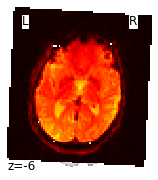

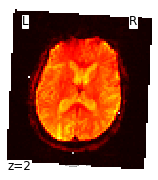

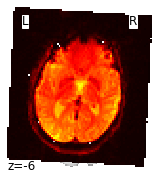

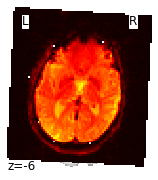

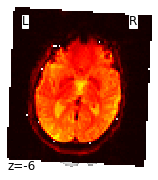

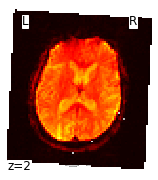

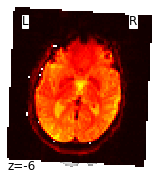

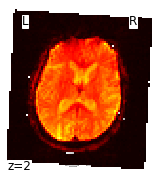

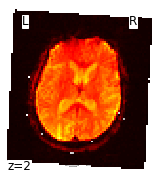

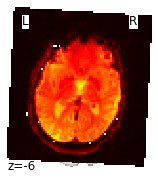

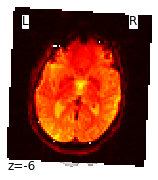

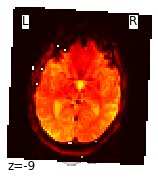

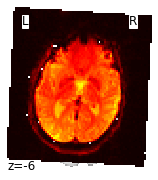

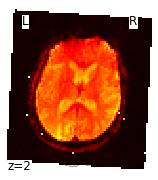

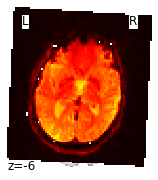

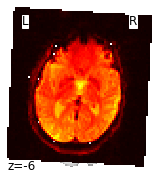

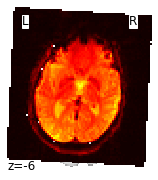

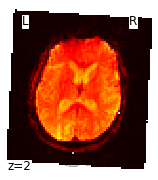

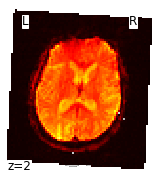

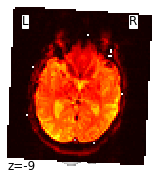

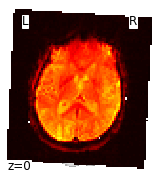

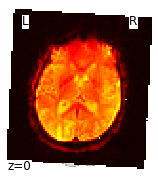

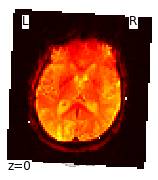

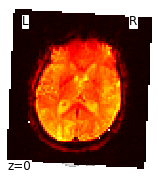

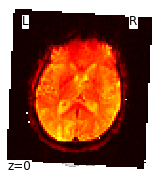

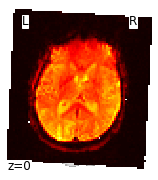

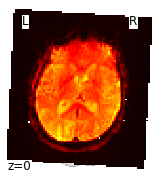

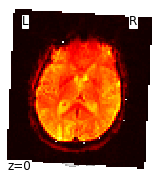

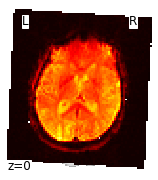

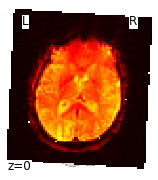

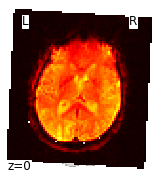

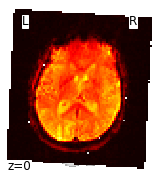

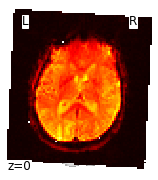

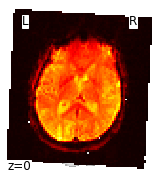

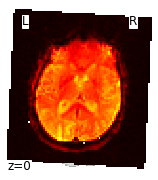

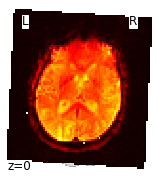

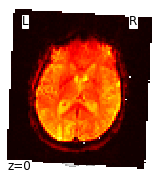

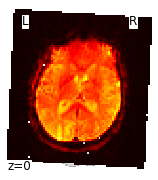

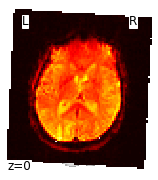

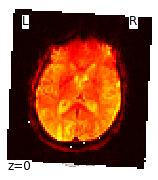

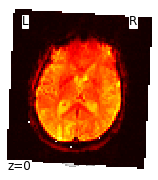

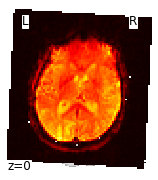

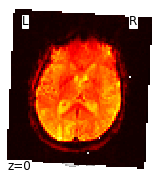

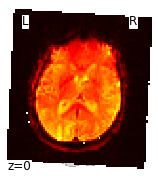

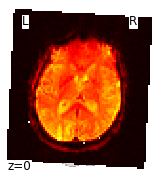

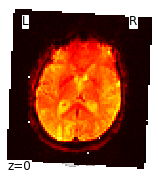

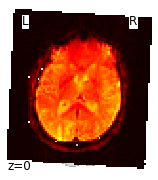

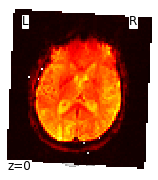

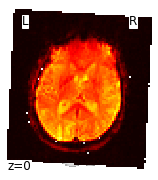

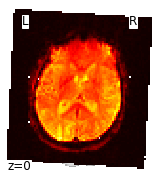

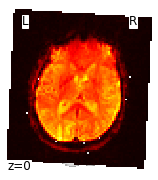

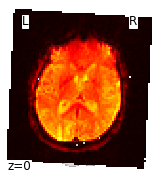

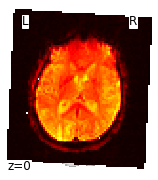

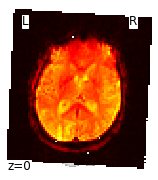

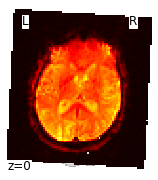

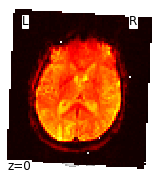

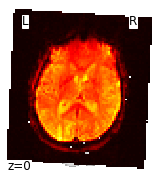

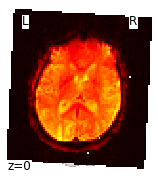

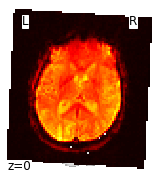

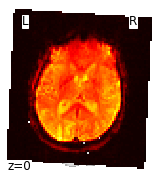

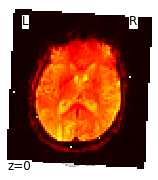

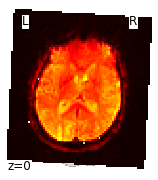

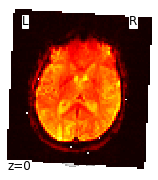

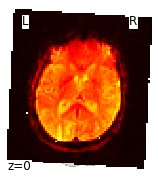

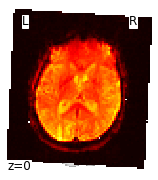

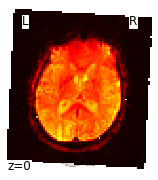

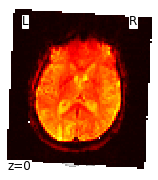

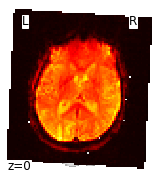

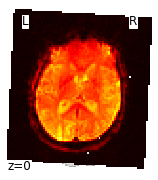

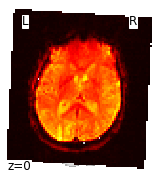

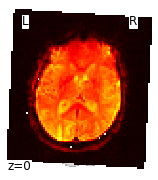

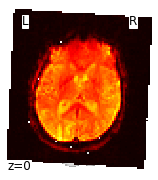

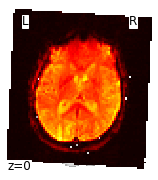

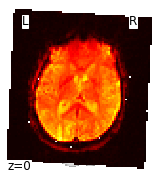

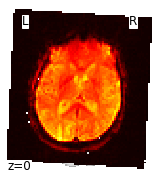

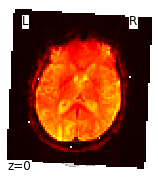

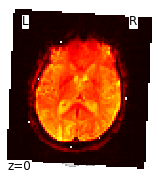

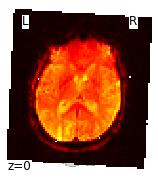

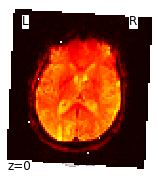

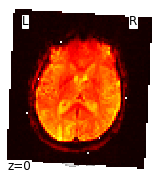

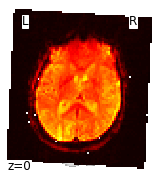

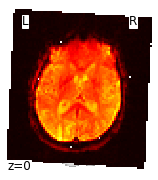

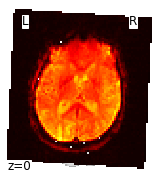

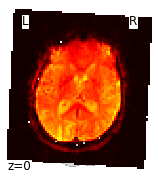

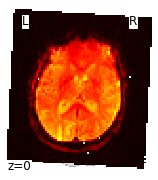

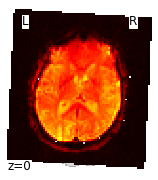

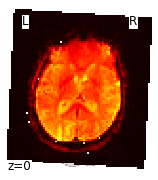

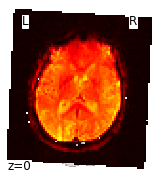

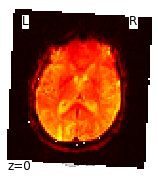

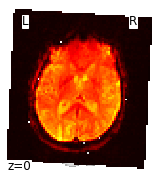

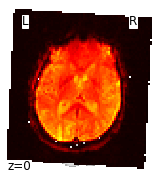

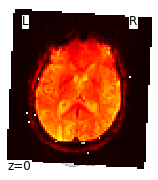

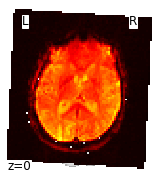

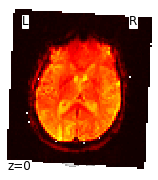

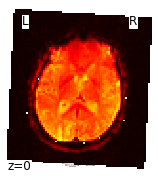

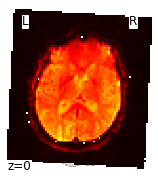

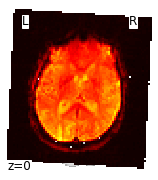

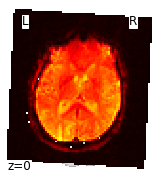

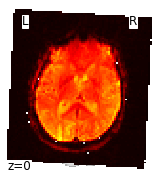

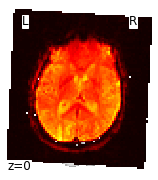

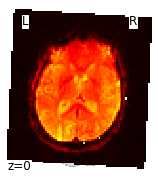

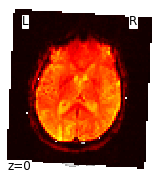

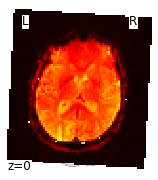

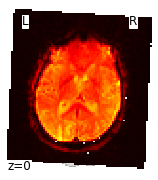

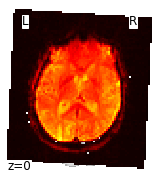

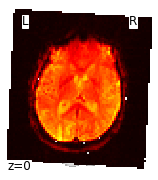

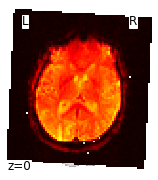

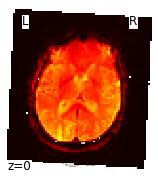

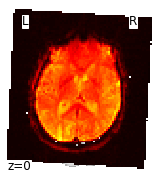

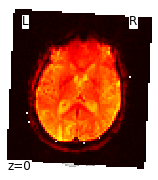

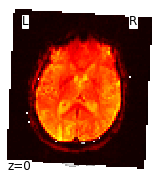

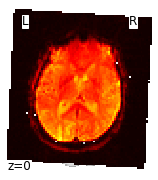

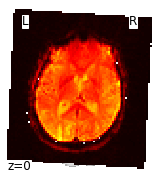

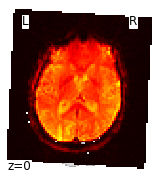

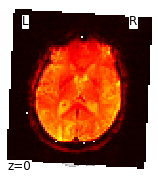

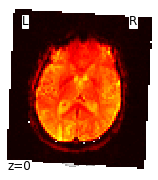

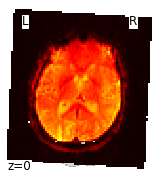

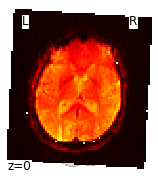

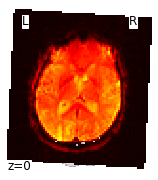

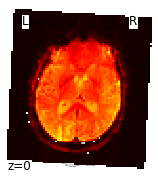

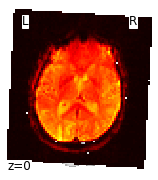

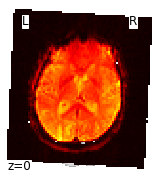

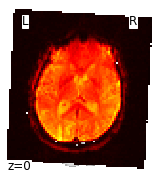

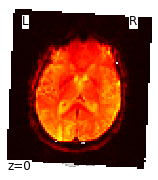

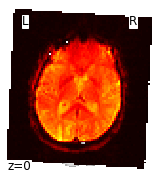

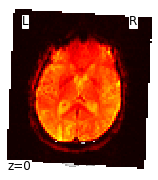

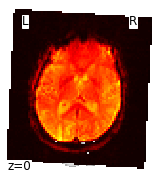

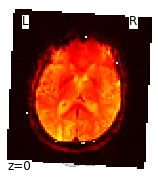

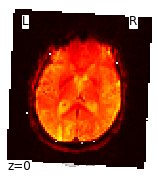

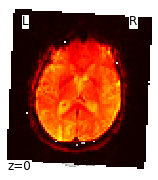

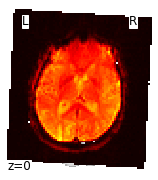

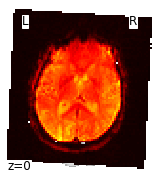

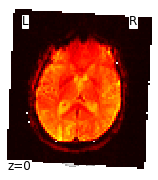

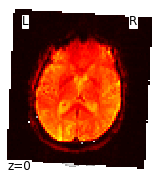

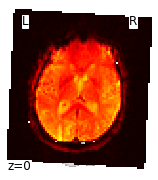

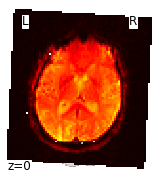

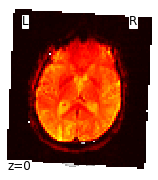

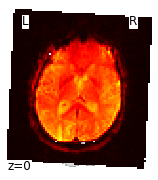

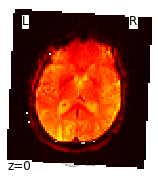

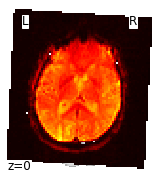

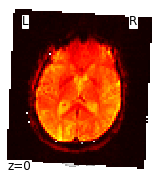

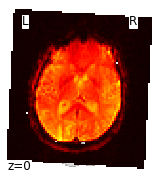

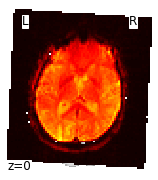

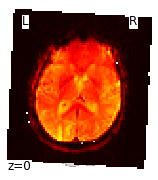

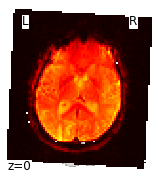

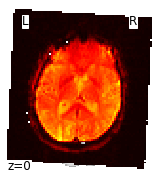

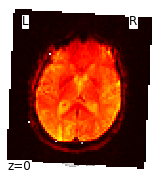

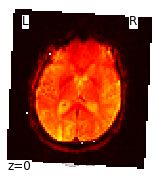

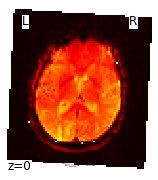

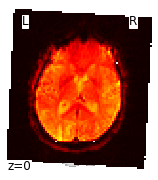

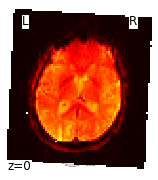

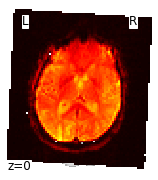

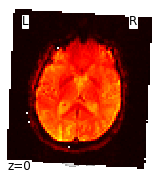

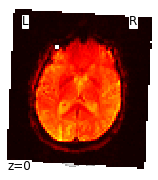

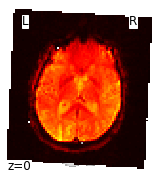

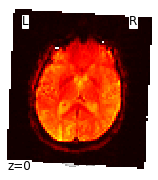

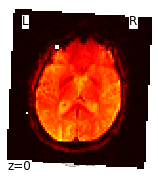

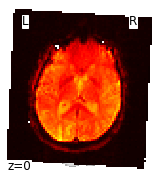

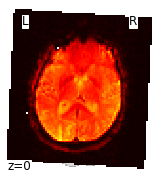

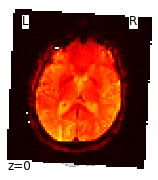

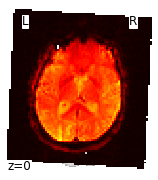

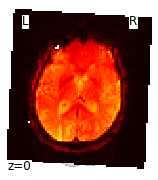

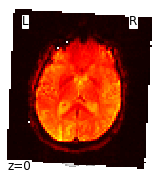

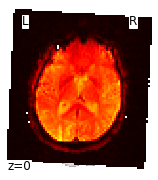

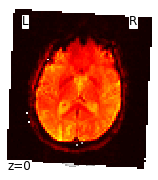

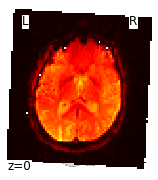

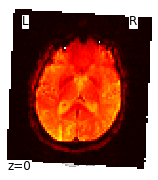

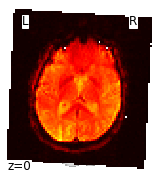

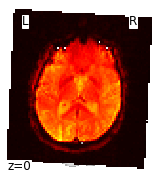

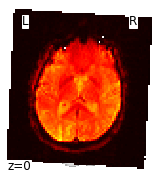

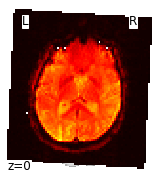

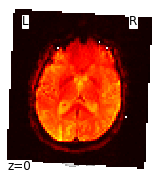

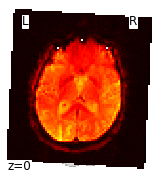

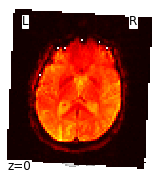

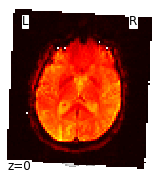

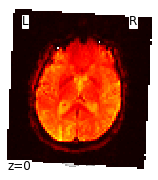

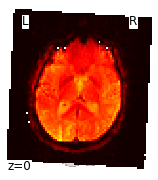

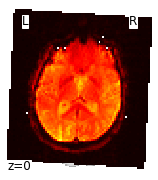

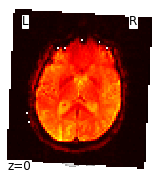

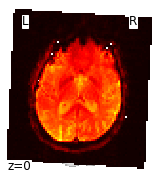

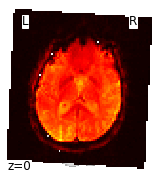

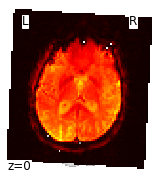

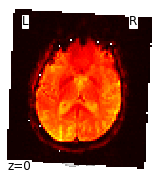

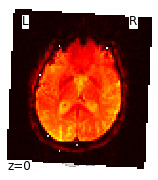

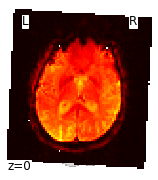

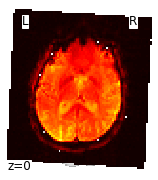

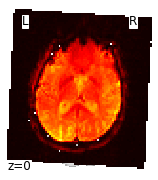

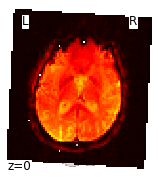

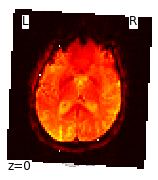

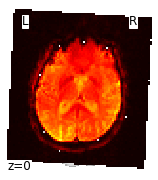

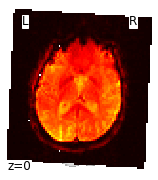

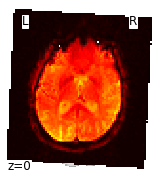

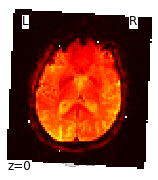

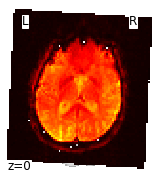

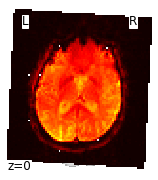

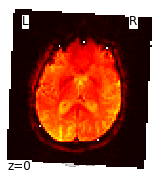

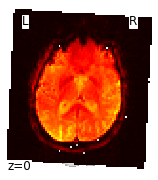

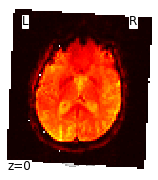

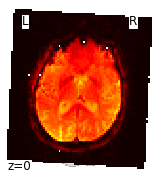

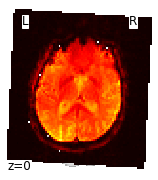

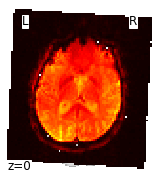

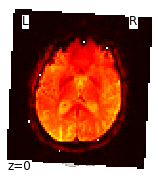

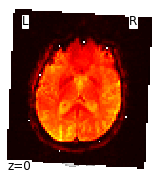

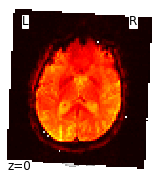

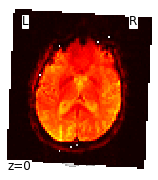

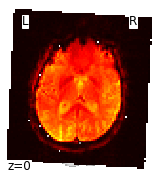

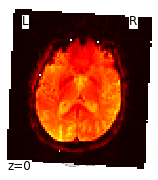

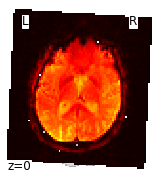

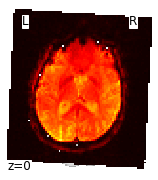

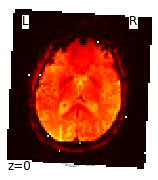

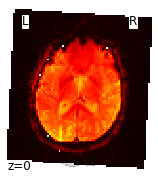

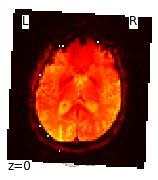

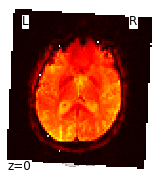

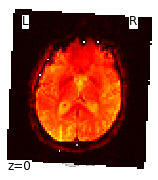

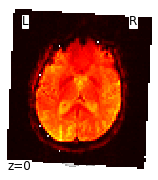

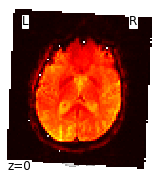

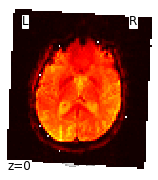

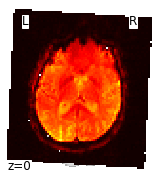

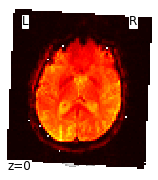

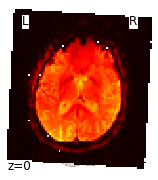

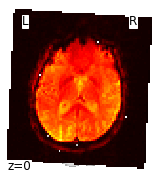

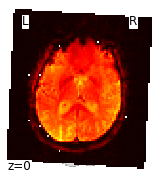

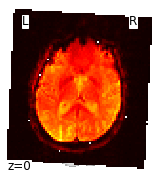

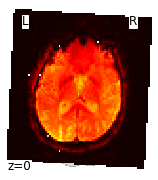

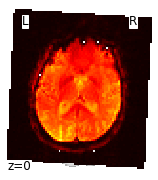

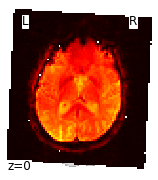

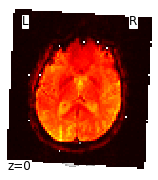

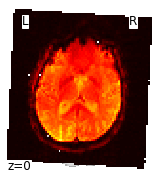

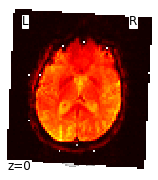

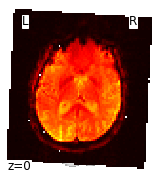

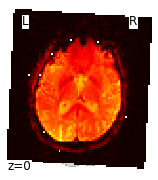

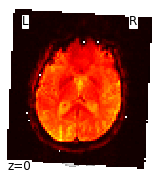

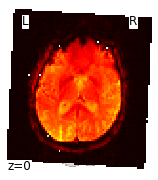

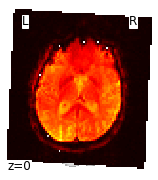

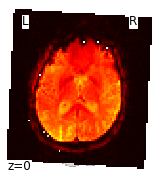

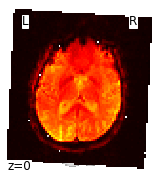

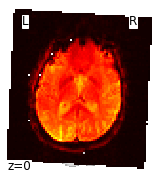

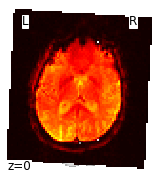

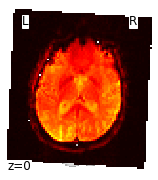

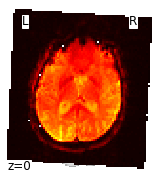

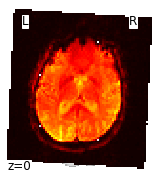

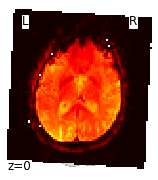

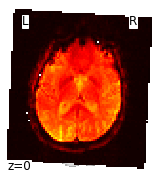

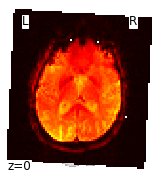

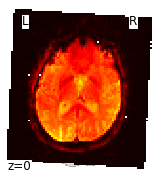

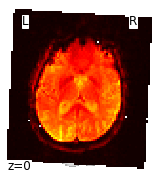

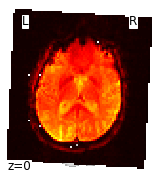

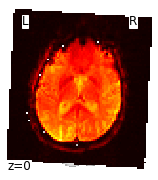

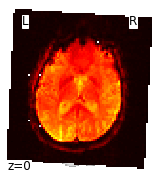

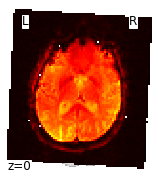

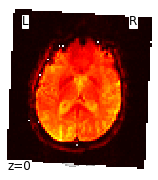

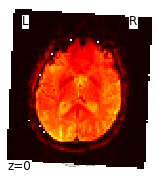

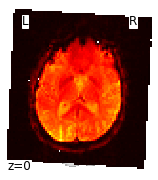

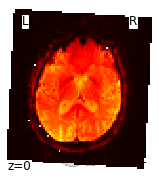

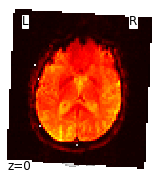

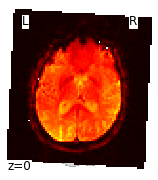

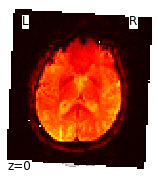

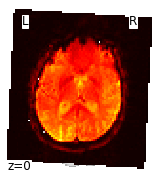

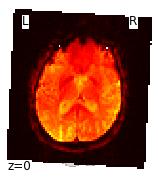

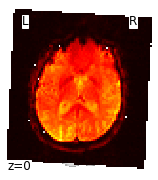

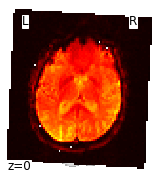

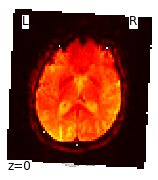

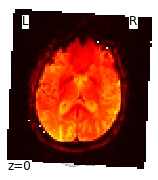

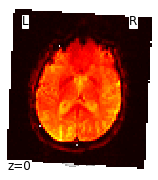

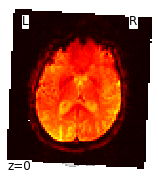

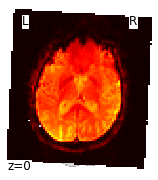

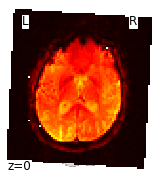

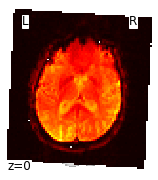

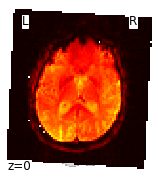

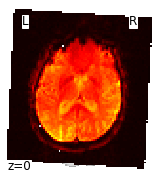

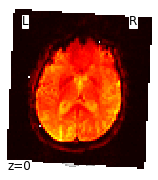

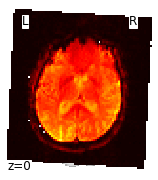

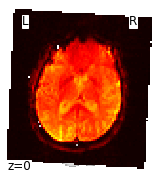

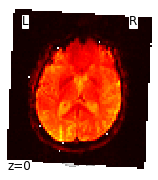

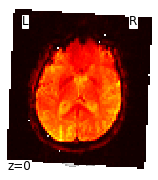

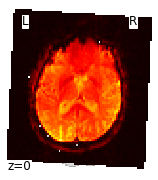

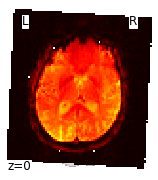

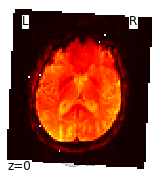

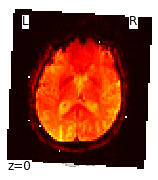

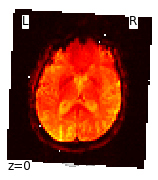

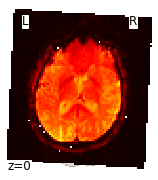

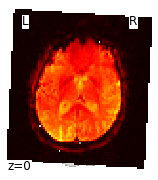

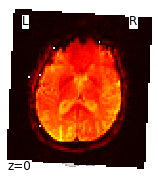

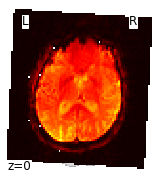

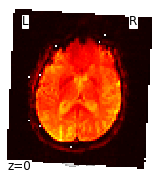

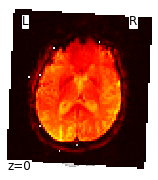

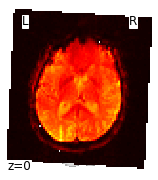

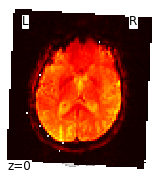

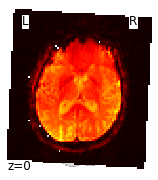

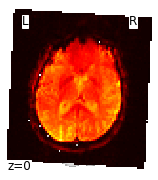

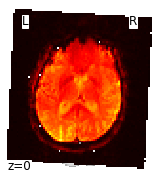

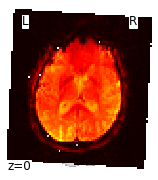

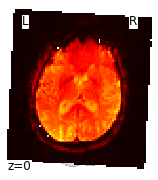

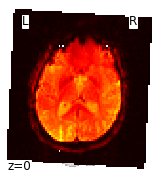

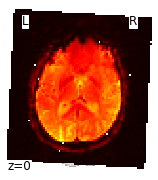

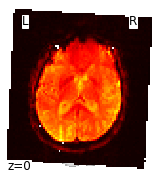

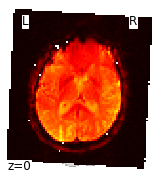

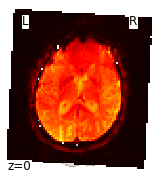

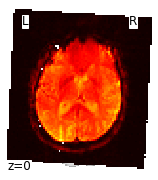

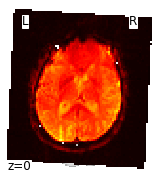

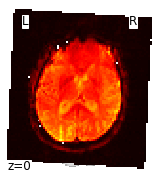

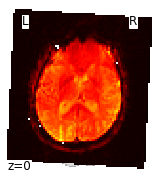

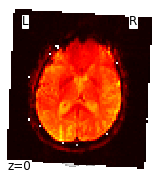

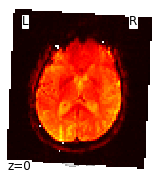

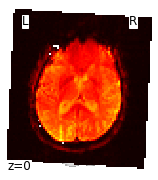

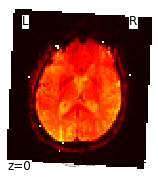

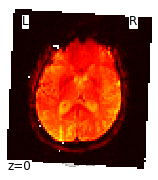

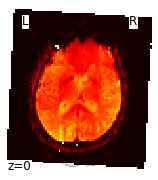

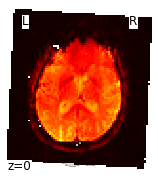

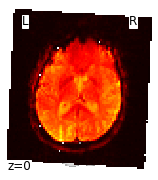

In [4]:
import nilearn
import nibabel as nib
from nilearn import image
from nilearn import plotting
test_orig = nib.load('/home/fnadeau/../../data/simexp/datasets/cimaq_20190901/sub-4835330/ses-V03/func/sub-4835330_ses-V03_task-memory_bold.nii.gz')
for img in image.iter_img(test_orig):
# img is now an in-memory 3D img
    plotting.plot_stat_map(img, threshold=3, display_mode="z", cut_coords=1,
                           colorbar=False)

In [163]:

uzbrain = unzip_obj(xpu(brainpath)) # 132.8MiB
zipbrain = get_bytes(xpu(brainpath))
# my_filters = [
#     {"id": lzma.FILTER_DELTA, "dist": 5},
#     {"id": lzma.FILTER_LZMA2, "preset": 7 | lzma.PRESET_EXTREME},
# ]

def to_xz_obj(inpt, dst_path):
    my_filters = [{"id": lzma.FILTER_LZMA2, "preset": 9 | lzma.PRESET_EXTREME}]
    lzma_cmp = lzma.LZMACompressor(filters=my_filter)
    with lzma.open(dst_path, "wb", filters=my_filters) as f:
        tmp = [lzma_cmp.compress(line) for line in
               tqdm(inpt.splitlines(keepends = True),
                    desc = "compressing")]
        xz_obj = b"".join((lzma_cmp.compress(line) for line in
               tqdm(inpt.splitlines(keepends = True),
                    desc = "compressing") + lzma_cmp.flush()))
        f.write(xz_obj)
    f.close()
    return xz_obj

xzbrain = to_xz_obj(uzbrain, dst_path = os.path.join(os.getcwd(), "shrinked_fmap.nii.xz"))




compressing:  11%|█         | 79362/730576 [00:12<02:00, 5419.21it/s]


compressing:  19%|█▉        | 140470/730576 [00:25<02:02, 4818.40it/s]


compressing:  27%|██▋       | 194781/730576 [00:37<01:57, 4561.55it/s]


compressing:  34%|███▎      | 246434/730576 [00:49<01:55, 4193.33it/s]


compressing:  41%|████      | 296441/730576 [01:01<01:40, 4302.50it/s]


compressing:  47%|████▋     | 343286/730576 [01:14<01:32, 4171.19it/s]


compressing:  53%|█████▎    | 389441/730576 [01:26<01:35, 3587.71it/s]


compressing:  60%|█████▉    | 436811/730576 [01:38<01:21, 3603.90it/s]


compressing:  66%|██████▋   | 485570/730576 [01:51<01:14, 3273.70it/s]


compressing:  73%|███████▎  | 533371/730576 [02:03<00:48, 4098.14it/s]


compressing:  80%|███████▉  | 581171/730576 [02:16<00:33, 4395.34it/s]


compressing:  86%|████████▌ | 628564/730576 [02:28<00:28, 3607.66it/s]


compressing:  93%|█████████▎| 676733/730576 [02:40<00:14, 3691.93it/s]


compressing:  99%|█████████▉| 724761/730576 [02:53<00:01, 3638.03it/s]


compressing: 100%|██████████| 730576/730576 [02:54<00:00, 4178.62it/s]


In [156]:
my_filters = [{"id": lzma.FILTER_LZMA2, "preset": 9 | lzma.PRESET_EXTREME}]
lzma_cmp = lzma.LZMACompressor(filters=my_filter)
xzbrain2 = [lzma_cmp.compress(line) for line in uzbrain.splitlines(keepends = True)]


In [157]:
# xzbrain2flush = xzbrain2

AttributeError: 'bytes' object has no attribute 'flush'

In [160]:
sizeof_fmt(len(uzbrain)), sizeof_fmt(len(xzbrain2)), sizeof_fmt(len(zipbrain))

('132.8MiB', '65.2MiB', '82.0MiB')

In [146]:
with lzma.open(os.path.join(os.getcwd(), "shrinked_brain.xz"), "wb") as xzfile:
    xzfile.write(xzbrain)
    xzfile.close()

In [5]:
display(sizeof_fmt(len(uzbrain)), sizeof_fmt(len(zipbrain)), sizeof_fmt(len(xzbrain)))

NameError: name 'sizeof_fmt' is not defined

In [149]:
print(sizeof_fmt(len(xzbrain)), sizeof_fmt(len(uzbrain)))

37.7KiB 132.8MiB


In [142]:
# test = tuple(zip(uzbrain.splitlines(), uzbrain.splitlines(keepends = True)))[0]
# test_encod = snif.get_bencod(uzbrain)
# test_decode = uzbrain.decode(test_encod, "replace")
utf8_brain = uzbrain.decode("cp437").encode()

In [116]:
utf32_test = "salut".encode("utf32")
decode_test = utf32_test.decode('Windows-1252')
utf32_test.decode("utf32")

'salut'

In [140]:
splitter = df(uzbrain.splitlines(keepends = True))
tst = splitter.values.tolist()[:10]
# splitter['encoding'] = [chardet.detect(row[1][0]) for row in tqdm(splitter.iloc[:splitter.shape[0]/4, :].iterrows())]
# enctest = [chardet.detect(line[0])['encoding'] for line in tqdm(tst)]
enctestutf32 = [uzbrain.decode("cp437") for line in tqdm(tst)]



100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


In [141]:
enctestutf32[0]# brain_chunk = uzbrain.splitlines()[0]
# delim = snif.get_delimiter()

KeyboardInterrupt: 

In [100]:
print(sizeof_fmt(len(uzbrain)))

132.8MiB


In [101]:
def xz_obj(inpt):
    my_filters = [{"id": lzma.FILTER_LZMA2, "preset": 9 | lzma.PRESET_EXTREME}]
    lzma_cmp = lzma.LZMACompressor(filters=my_filter)
    tmp = lzma_cmp.compress(inpt)
    xz_obj = lzma_cmp.flush()
    return xz_obj


In [102]:
xz_brain = xz_obj(uzbrain)

In [103]:
print(sizeof_fmt(len(xz_brain)))
# help(lzma_cmp.compress)

44.2KiB


In [27]:
import lzma
import tarfile
from sniffbytes import get_bytes
from sizeof_fmt import sizeof_fmt

# def to_xz(src_dir, dst_dir):
#     allfiles = [os.path.join(src_dir, item)
#                 for item in os.listdir(src_dir)]
#     my_filters = [
# #         {"id": lzma.FILTER_DELTA, "dist": 5},
#         {"id": lzma.FILTER_LZMA2, "preset": 9 | lzma.PRESET_EXTREME},
#     ]
#     for fpath in allfiles:
#         with lzma.open(os.path.join(
#             dst_dir, os.path.basename(fpath) + ".xz", "w"),
#                        filters=my_filters) as xzfile:
#             compressed = xzfile.compress(get_bytes(fpath)).flush()
#             xzfile.write
            
def to_xz(src_path, dst_path):
    my_filters = [{"id": lzma.FILTER_LZMA2, "preset": 9 | lzma.PRESET_EXTREME}]
    lzma_cmp = lzma.LZMACompressor(filters=my_filter)
    with lzma.open(os.path.join(
        dst_dir, os.path.basename(fpath) + ".xz", "w"),
                   filters=my_filters) as xzfile:
        compressed = lzma_comp.compress(get_bytes(src_path))

test01xz

AttributeError: 'bytes' object has no attribute 'flush'

In [86]:
import gzip
import nibabel
from sizeof_fmt import sizeof_fmt
bigbrain = brainpath
brainfile = nibabel.load(bigbrain)
brainbytes = unzip_obj(bigbrain)
shrinked_head = lzma_cmp.compress(brainbytes)
print((sizeof_fmt(len(brainbytes)), sizeof_fmt(len(shrinked_head))))

FileNotFoundError: [Errno 2] No such file or directory: '/home/fnadeau/../../data/simexp/datasets/cimaq_20190901/sub-4835330/ses-V03/func/sub-4835330_ses-V03_task-memory_bold.nii'

In [73]:

import gzip
import shutil
with gzip.open('file.txt.gz', 'rb') as f_in:
    with open('file.txt', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

filename    ext parent  \
0                sub-4835330_ses-V03_FLAIR    .gz   anat   
1                sub-4835330_ses-V03_FLAIR  .json   anat   
2                   sub-4835330_ses-V03_PD  .json   anat   
3                   sub-4835330_ses-V03_PD    .gz   anat   
4                  sub-4835330_ses-V03_T1w  .json   anat   
5                  sub-4835330_ses-V03_T1w    .gz   anat   
6               sub-4835330_ses-V03_T2star    .gz   anat   
7               sub-4835330_ses-V03_T2star  .json   anat   
8                  sub-4835330_ses-V03_T2w  .json   anat   
9                  sub-4835330_ses-V03_T2w    .gz   anat   
10                 sub-4835330_ses-V03_dwi  .bval    dwi   
11                 sub-4835330_ses-V03_dwi    .gz    dwi   
12                 sub-4835330_ses-V03_dwi  .bvec    dwi   
13                 sub-4835330_ses-V03_dwi  .json    dwi   
14  sub-4835330_ses-V03_mod-T1w_defacemask    .gz   anat   
15          sub-4835330_ses-V03_run-01_epi  .json   fmap   
16          sub-4835330_ses-V03_run-01_epi    .gz   fmap   
17   sub-4835330_ses-V03_run-01_magnitude1  .json   fmap   
18   sub-4835330_ses-V03_run-01_magnitude1    .gz   fmap   
19   sub-4835330_ses-V03_run-01_magnitude2    .gz   fmap   
20   sub-4835330_ses-V03_run-01_magnitude2  .json   fmap   
21    sub-4835330_ses-V03_run-01_phasediff  .json   fmap   
22    sub-4835330_ses-V03_run-01_phasediff    .gz   fmap   
23          sub-4835330_ses-V03_run-02_epi    .gz   fmap   
24          sub-4835330_ses-V03_run-02_epi  .json   fmap   
25   sub-4835330_ses-V03_run-02_magnitude1    .gz   fmap   
26   sub-4835330_ses-V03_run-02_magnitude1  .json   fmap   
27   sub-4835330_ses-V03_run-02_magnitude2    .gz   fmap   
28   sub-4835330_ses-V03_run-02_magnitude2  .json   fmap   
29    sub-4835330_ses-V03_run-02_phasediff  .json   fmap   
30    sub-4835330_ses-V03_run-02_phasediff    .gz   fmap   
31          sub-4835330_ses-V03_run-03_epi    .gz   fmap   
32          sub-4835330_ses-V03_run-03_epi  .json   fmap   
33          sub-4835330_ses-V03_run-04_epi  .json   fmap   
34          sub-4835330_ses-V03_run-04_epi    .gz   fmap   
35    sub-4835330_ses-V03_task-memory_bold  .json   func   
36    sub-4835330_ses-V03_task-memory_bold    .gz   func   
37      sub-4835330_ses-V03_task-rest_bold  .json   func   
38      sub-4835330_ses-V03_task-rest_bold    .gz   func   

                                               fpaths  
0   /home/fnadeau/../../data/simexp/datasets/cimaq...  
1   /home/fnadeau/../../data/simexp/datasets/cimaq...  
2   /home/fnadeau/../../data/simexp/datasets/cimaq...  
3   /home/fnadeau/../../data/simexp/datasets/cimaq...  
4   /home/fnadeau/../../data/simexp/datasets/cimaq...  
5   /home/fnadeau/../../data/simexp/datasets/cimaq...  
6   /home/fnadeau/../../data/simexp/datasets/cimaq...  
7   /home/fnadeau/../../data/simexp/datasets/cimaq...  
8   /home/fnadeau/../../data/simexp/datasets/cimaq...  
9   /home/fnadeau/../../data/simexp/datasets/cimaq...  
10  /home/fnadeau/../../data/simexp/datasets/cimaq...  
11  /home/fnadeau/../../data/simexp/datasets/cimaq...  
12  /home/fnadeau/../../data/simexp/datasets/cimaq...  
13  /home/fnadeau/../../data/simexp/datasets/cimaq...  
14  /home/fnadeau/../../data/simexp/datasets/cimaq...  
15  /home/fnadeau/../../data/simexp/datasets/cimaq...  
16  /home/fnadeau/../../data/simexp/datasets/cimaq...  
17  /home/fnadeau/../../data/simexp/datasets/cimaq...  
18  /home/fnadeau/../../data/simexp/datasets/cimaq...  
19  /home/fnadeau/../../data/simexp/datasets/cimaq...  
20  /home/fnadeau/../../data/simexp/datasets/cimaq...  
21  /home/fnadeau/../../data/simexp/datasets/cimaq...  
22  /home/fnadeau/../../data/simexp/datasets/cimaq...  
23  /home/fnadeau/../../data/simexp/datasets/cimaq...  
24  /home/fnadeau/../../data/simexp/datasets/cimaq...  
25  /home/fnadeau/../../data/simexp/datasets/cimaq...  
26  /home/fnadeau/../../data/simexp/datasets/cimaq...  
27  /home/fnadeau/../../data/simexp/datasets/cimaq...  
28  /home

68.2MiB


In [ ]:
def bids_tarball(sub_dir):
    

In [ ]:
import gzip
import shutil
with gzip.open('file.txt.gz', 'rb') as f_in:
    with open('file.txt', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [ ]:
def decompress_lzma(data):
    results = []
    while True:
        decomp = LZMADecompressor(FORMAT_AUTO, None, None)
        try:
            res = decomp.decompress(data)
        except LZMAError:
            if results:
                break  # Leftover data is not a valid LZMA/XZ stream; ignore it.
            else:
                raise  # Error on the first iteration; bail out.
        results.append(res)
        data = decomp.unused_data
        if not data:
            break
        if not decomp.eof:
            raise LZMAError("Compressed data ended before the end-of-stream marker was reached")
    return b"".join(results)

In [39]:
def xtrct_lzma(inpt):
    try:
        back2bytes = lzma.decompress(test01xz)
    except LZMAError:
        
# back2bytes

LZMAError: Compressed data ended before the end-of-stream marker was reached

In [64]:
dir(bytes)

['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getnewargs__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmod__',
 '__rmul__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'capitalize',
 'center',
 'count',
 'decode',
 'endswith',
 'expandtabs',
 'find',
 'fromhex',
 'hex',
 'index',
 'isalnum',
 'isalpha',
 'isdigit',
 'islower',
 'isspace',
 'istitle',
 'isupper',
 'join',
 'ljust',
 'lower',
 'lstrip',
 'maketrans',
 'partition',
 'replace',
 'rfind',
 'rindex',
 'rjust',
 'rpartition',
 'rsplit',
 'rstrip',
 'split',
 'splitlines',
 'startswith',
 'strip',
 'swapcase',
 'title',
 'translate',
 'upper',
 'zfill']

In [36]:
import chardet
import sniffbytes as sniff
test01xz.decode(sniff.get_bencod(test01xz)).encode()

b'\xc2\xa77zXZ\x00\x00\x04\xd0\xa2\xd0\xbe\xe2\x94\xa4F\x02\x00!\x01\x1c\x00\x00\x00\x10\xc2\xa4X\xe2\x95\xa0'

In [47]:
ls(xpu('~/../../media'))#'/media/francois/seagate_1tb'))

[]

In [63]:
sizeof_fmt(test01xz.get_value)

AttributeError: 'bytes' object has no attribute 'get_value'

In [3]:
nested = [[[[(row[1].pscid, row[1].dccid)], row[1].to_dict()]]
          for row in cimaq_ids.iterrows()]

In [ ]:
import lzma
import tarfile
from sniffbytes import get_bytes

def to_xz(src_dir, dst_dir):
    allfiles = [os.path.join(src_dir, item)
                for item in os.listdir(src_dir)]
    my_filters = [
#         {"id": lzma.FILTER_DELTA, "dist": 5},
        {"id": lzma.FILTER_LZMA2, "preset": 9 | lzma.PRESET_EXTREME},
    ]
    for fpath in allfiles:
        with lzma.open(os.path.join(
            dst_dir, os.path.basename(fpath) + ".xz", "w"),
                       filters=my_filters) as xzfile:
            compressed = xzfile.compress(get_bytes(fpath)).flush()
            xzfile.write(compressed)
        xzfile.close()
    
def reset(tarinfo):
    tarinfo.uid = tarinfo.gid = 0
    tarinfo.uname = tarinfo.gname = "root"
    return tarinfo

def to_tar(src_dir, dst_dir):
    with tarfile.open("sample.tar.xz", "w:xz") as mytar:
        mytar.add(to_xz("foo"), filter=reset)
    tar.close()    

In [ ]:
source_dir = "./source"
dest_dir = "./unpacked"
source_file_size = 65536
archive_name = "archive.tar.gz"


print("Creating source file with random text...")
create_source_files(source_dir, source_file_size)
okay()

print("Compressing files to %s..." % archive_name)
tar = tarfile.open(archive_name, "w:gz")
for file_name in glob.glob(os.path.join(source_dir, "*")):
    print("  Adding %s..." % file_name)
    tar.add(file_name, os.path.basename(file_name))
tar.close()

In [3]:
from cimaq import cimaq

cimaq01 = cimaq(d0319)
cimaq02 = cimaq(d0919)
# newdir = xpu("~/cimaq_both_scanfiles")
# os.makedirs(newdir, exist_ok = True)

# tmpsort = df(pd.concat([pd.concat([cimaq_ids.sort_values("dccid"),
#              scanfiles01.sort_values(0)[1]], axis = 1).sort_values("pscid"),
#   scanfiles02.sort_values(0)[1]], axis = 1).values.flat.base)

# new = df(((row[1][2], row[1][3]+row[1][4])
#           for row in tmpsort.iterrows()),
#          columns = ["subid", "files"])

# [(os.makedirs(pjoin(newdir, row[1].subid),
#               exist_ok = True),
#  shutil.move(row[1].files, pjoin(newdir, dname(row[1]),
#                         row[1].subid + "_" + bname(row[1]))))

#  for row in new.iterrows()]

TypeError: object() takes no parameters

subid                                              files
0   8192087_619278  [/home/fnadeau/../../data/simexp/datasets/cima...
1   5522727_267168  [/home/fnadeau/../../data/simexp/datasets/cima...
2   4835330_677561  [/home/fnadeau/../../data/simexp/datasets/cima...
3   8330218_413474  [/home/fnadeau/../../data/simexp/datasets/cima...
4   3431566_164965  [/home/fnadeau/../../data/simexp/datasets/cima...
..             ...                                                ...
89  7485585_386333  [/home/fnadeau/../../data/simexp/datasets/cima...
90  8758136_886007  [/home/fnadeau/../../data/simexp/datasets/cima...
91  8875385_437101  [/home/fnadeau/../../data/simexp/datasets/cima...
92  3123186_920577  [/home/fnadeau/../../data/simexp/datasets/cima...
93  3750063_956049  [/home/fnadeau/../../data/simexp/datasets/cima...

[94 rows x 2 columns]

In [86]:
scanfiles01 = [load_subjects(cimaq_dir01).loc[cimaq_ids.index],
               get_qc_liat()]
scanfiles02 = load_subjects(cimaq_dir02).loc[scanfiles01.index]
display(scanfiles01.sort_values(0), cimaq_ids.sort_values(0), scanfiles02)

loading subject files: 100%|██████████| 178/178 [00:04<00:00, 43.94it/s]


0                                                  1
0   924191  [/home/fnadeau/../../data/simexp/datasets/cima...
1   763590  [/home/fnadeau/../../data/simexp/datasets/cima...
2   517070  [/home/fnadeau/../../data/simexp/datasets/cima...
3   403131  [/home/fnadeau/../../data/simexp/datasets/cima...
4   765779  [/home/fnadeau/../../data/simexp/datasets/cima...
..     ...                                                ...
89  700293  [/home/fnadeau/../../data/simexp/datasets/cima...
90  810098  [/home/fnadeau/../../data/simexp/datasets/cima...
91  199158  [/home/fnadeau/../../data/simexp/datasets/cima...
92  597569  [/home/fnadeau/../../data/simexp/datasets/cima...
93  195016  [/home/fnadeau/../../data/simexp/datasets/cima...

[94 rows x 2 columns]

0                                                  1
0   5522727  [/home/fnadeau/../../data/simexp/datasets/cima...
1   4460076  [/home/fnadeau/../../data/simexp/datasets/cima...
2   4932877  [/home/fnadeau/../../data/simexp/datasets/cima...
3   5359706  [/home/fnadeau/../../data/simexp/datasets/cima...
4   7435733  [/home/fnadeau/../../data/simexp/datasets/cima...
..      ...                                                ...
89  6427603  [/home/fnadeau/../../data/simexp/datasets/cima...
90  8656527  [/home/fnadeau/../../data/simexp/datasets/cima...
91  3970362  [/home/fnadeau/../../data/simexp/datasets/cima...
92  3980811  [/home/fnadeau/../../data/simexp/datasets/cima...
93  8980899  [/home/fnadeau/../../data/simexp/datasets/cima...

[94 rows x 2 columns]

In [84]:
display(scanfiles01[1], scanfiles02[1])

0     [/home/fnadeau/../../data/simexp/datasets/cima...
1     [/home/fnadeau/../../data/simexp/datasets/cima...
2     [/home/fnadeau/../../data/simexp/datasets/cima...
3     [/home/fnadeau/../../data/simexp/datasets/cima...
4     [/home/fnadeau/../../data/simexp/datasets/cima...
                            ...                        
89    [/home/fnadeau/../../data/simexp/datasets/cima...
90    [/home/fnadeau/../../data/simexp/datasets/cima...
91    [/home/fnadeau/../../data/simexp/datasets/cima...
92    [/home/fnadeau/../../data/simexp/datasets/cima...
93    [/home/fnadeau/../../data/simexp/datasets/cima...
Name: 1, Length: 94, dtype: object

0     [/home/fnadeau/../../data/simexp/datasets/cima...
1     [/home/fnadeau/../../data/simexp/datasets/cima...
2     [/home/fnadeau/../../data/simexp/datasets/cima...
3     [/home/fnadeau/../../data/simexp/datasets/cima...
4     [/home/fnadeau/../../data/simexp/datasets/cima...
                            ...                        
89    [/home/fnadeau/../../data/simexp/datasets/cima...
90    [/home/fnadeau/../../data/simexp/datasets/cima...
91    [/home/fnadeau/../../data/simexp/datasets/cima...
92    [/home/fnadeau/../../data/simexp/datasets/cima...
93    [/home/fnadeau/../../data/simexp/datasets/cima...
Name: 1, Length: 94, dtype: object

In [24]:
# colnames = ['pscid', 'dccid', 'visit', 'archive', 'seriesuid', 'echotime', 'qc']

# def get_qc_list() -> list:
#     return pd.read_csv(pjoin(os.getcwd(),
#                              "sub_list_TaskQC.csv"),
#                        header = None).astype(str).values.tolist()[0][1:]

# def load_series_uid() -> pd.DataFrame:
#     qcok = get_qc_list()
#     return df((row[1] for row in tqdm(pd.read_csv(
#         pjoin(os.getcwd(), "seriesUID_qc.csv")).iterrows(),
#                                       desc = "loading")
#               if str(row[1].CandID) in qcok))

# def get_cimaq_ids() -> list:
#     return df((itm.split("_") + [itm] for itm in
#                pd.Series(("_".join((str(itm) for itm in
#                                     row[1].values)) for row in
#                           load_series_uid().iloc[:, :2].iterrows())).unique()),
#               columns = ["pscid", "dccid", "subid"])

# def group_series_uid() -> dict:
#     series_uid = load_series_uid()
#     qc_ok = get_qc_list()    
#     return dict(((str(grp),
#                    df(series_uid).groupby("CandID").get_group(grp).reset_index(drop = True).to_dict())
#                   for grp in tqdm(list(df(series_uid).groupby("CandID").groups),
#                                   desc = "grouping")
#                  if str(grp) in qc_ok))
qcok = get_qc_list()
uids = load_series_uid()
uids

loading: 3375it [00:00, 6066.88it/s]


PSCID  CandID Visit                                        Archive  \
0     8192087  619278   V03  DCM_2015-05-08_ImagingUpload-14-14-grO2zP.tar   
1     8192087  619278   V03  DCM_2015-05-08_ImagingUpload-14-14-grO2zP.tar   
2     8192087  619278   V03  DCM_2015-05-08_ImagingUpload-14-14-grO2zP.tar   
3     8192087  619278   V03  DCM_2015-05-08_ImagingUpload-14-14-grO2zP.tar   
4     8192087  619278   V03  DCM_2015-05-08_ImagingUpload-14-14-grO2zP.tar   
...       ...     ...   ...                                            ...   
3370  3494204  337021   V10  DCM_2018-04-04_ImagingUpload-11-16-ioLmAM.tar   
3371  3494204  337021   V10  DCM_2018-04-04_ImagingUpload-11-16-ioLmAM.tar   
3372  3494204  337021   V10  DCM_2018-04-04_ImagingUpload-11-16-ioLmAM.tar   
3373  3494204  337021   V10  DCM_2018-04-04_ImagingUpload-11-16-ioLmAM.tar   
3374  3494204  337021   V10  DCM_2018-04-04_ImagingUpload-11-16-ioLmAM.tar   

                                              SeriesUID  EchoTime    QC  
0     1.3.12.2.1107.5.2.32.35049.2015050810170216329...   0.00298  Pass  
1     1.3.12.2.1107.5.2.32.35049.2015050810251346812...   0.12300  Pass  
2     1.3.12.2.1107.5.2.32.35049.2015050810333048296...   0.02000  Pass  
3     1.3.12.2.1107.5.2.32.35049.2015050810372458752...   0.09600  Pass  
4     1.3.12.2.1107.5.2.32.35049.2015050810425167447...   0.09600  Pass  
...                                                 ...       ...   ...  
3370  1.3.12.2.1107.5.2.43.167006.201804041514566309...   0.09300  Pass  
3371  1.3.12.2.1107.5.2.43.167006.201804041518353021...   0.12000  Pass  
3372  1.3.12.2.1107.5.2.43.167006.201804041520034816...   0.02000  Pass  
3373  1.3.12.2.1107.5.2.43.167006.201804041520034816...   0.02000   NaN  
3374  1.3.12.2.1107.5.2.43.167006.201804041523366105...   0.06400   NaN  

[2005 rows x 7 columns]

In [48]:
display(scanfiles01, scanfiles02)#, scanfiles02)

{'924191': ['/home/fnadeau/../../data/simexp/datasets/cimaq_03-19/sub-924191/ses-4/func/sub-924191_ses-4_task-rest_bold.nii.gz',
  '/home/fnadeau/../../data/simexp/datasets/cimaq_03-19/sub-924191/ses-4/func/sub-924191_ses-4_task-rest_bold.json',
  '/home/fnadeau/../../data/simexp/datasets/cimaq_03-19/sub-924191/ses-4/anat/sub-924191_ses-4_T1w.json',
  '/home/fnadeau/../../data/simexp/datasets/cimaq_03-19/sub-924191/ses-4/anat/sub-924191_ses-4_T1w.nii.gz',
  '/home/fnadeau/../../data/simexp/datasets/cimaq_03-19/sub-924191/ses-4/anat/sub-924191_ses-4_FLAIR.nii.gz',
  '/home/fnadeau/../../data/simexp/datasets/cimaq_03-19/sub-924191/ses-4/anat/sub-924191_ses-4_T2w.json',
  '/home/fnadeau/../../data/simexp/datasets/cimaq_03-19/sub-924191/ses-4/anat/sub-924191_ses-4_T2star.nii.gz',
  '/home/fnadeau/../../data/simexp/datasets/cimaq_03-19/sub-924191/ses-4/anat/sub-924191_ses-4_T2w.nii.gz',
  '/home/fnadeau/../../data/simexp/datasets/cimaq_03-19/sub-924191/ses-4/anat/sub-924191_ses-4_T2star.jso

{'5522727': ['/home/fnadeau/../../data/simexp/datasets/cimaq_20190901/sub-5522727/ses-V03/func/sub-5522727_ses-V03_task-rest_bold.nii.gz',
  '/home/fnadeau/../../data/simexp/datasets/cimaq_20190901/sub-5522727/ses-V03/func/sub-5522727_ses-V03_task-memory_bold.nii.gz',
  '/home/fnadeau/../../data/simexp/datasets/cimaq_20190901/sub-5522727/ses-V03/func/sub-5522727_ses-V03_task-memory_bold.json',
  '/home/fnadeau/../../data/simexp/datasets/cimaq_20190901/sub-5522727/ses-V03/func/sub-5522727_ses-V03_task-rest_bold.json',
  '/home/fnadeau/../../data/simexp/datasets/cimaq_20190901/sub-5522727/ses-V03/dwi/sub-5522727_ses-V03_dwi.nii.gz',
  '/home/fnadeau/../../data/simexp/datasets/cimaq_20190901/sub-5522727/ses-V03/dwi/sub-5522727_ses-V03_dwi.json',
  '/home/fnadeau/../../data/simexp/datasets/cimaq_20190901/sub-5522727/ses-V03/dwi/sub-5522727_ses-V03_dwi.bval',
  '/home/fnadeau/../../data/simexp/datasets/cimaq_20190901/sub-5522727/ses-V03/dwi/sub-5522727_ses-V03_dwi.bvec',
  '/home/fnadeau/..

In [8]:
cimaq_ids = get_cimaq_ids()
cimaq_ids.to_csv(pjoin(os.getcwd(), "cimaq_valid_ids.tsv"),
                 sep = "\t", header = 0, index = None)

loading: 3375it [00:00, 5702.57it/s]


In [22]:
cimaq_ids = get_cimaq_ids()
cimaq_ids

subdirs = [pjoin(cimaq_dir_0919, sub) for sub in
           snif.filter_lst_inc(cimaq_ids.pscid.values.tolist(),
                               ls(cimaq_dir_0919))]
subdirs

loading: 3375it [00:00, 5641.79it/s]


['/home/fnadeau/../../data/simexp/datasets/cimaq_20190901/sub-5522727',
 '/home/fnadeau/../../data/simexp/datasets/cimaq_20190901/sub-7435733',
 '/home/fnadeau/../../data/simexp/datasets/cimaq_20190901/sub-5381177',
 '/home/fnadeau/../../data/simexp/datasets/cimaq_20190901/sub-3708747',
 '/home/fnadeau/../../data/simexp/datasets/cimaq_20190901/sub-4050235',
 '/home/fnadeau/../../data/simexp/datasets/cimaq_20190901/sub-9494076',
 '/home/fnadeau/../../data/simexp/datasets/cimaq_20190901/sub-6023087',
 '/home/fnadeau/../../data/simexp/datasets/cimaq_20190901/sub-6417837',
 '/home/fnadeau/../../data/simexp/datasets/cimaq_20190901/sub-4694616',
 '/home/fnadeau/../../data/simexp/datasets/cimaq_20190901/sub-4398745',
 '/home/fnadeau/../../data/simexp/datasets/cimaq_20190901/sub-4344061',
 '/home/fnadeau/../../data/simexp/datasets/cimaq_20190901/sub-7113680',
 '/home/fnadeau/../../data/simexp/datasets/cimaq_20190901/sub-5375537',
 '/home/fnadeau/../../data/simexp/datasets/cimaq_20190901/sub-79

In [4]:
series_uid = load_series_uid()
series_uid

loading: 3375it [00:00, 6221.43it/s]


PSCID  CandID Visit                                        Archive  \
0     8192087  619278   V03  DCM_2015-05-08_ImagingUpload-14-14-grO2zP.tar   
1     8192087  619278   V03  DCM_2015-05-08_ImagingUpload-14-14-grO2zP.tar   
2     8192087  619278   V03  DCM_2015-05-08_ImagingUpload-14-14-grO2zP.tar   
3     8192087  619278   V03  DCM_2015-05-08_ImagingUpload-14-14-grO2zP.tar   
4     8192087  619278   V03  DCM_2015-05-08_ImagingUpload-14-14-grO2zP.tar   
...       ...     ...   ...                                            ...   
3370  3494204  337021   V10  DCM_2018-04-04_ImagingUpload-11-16-ioLmAM.tar   
3371  3494204  337021   V10  DCM_2018-04-04_ImagingUpload-11-16-ioLmAM.tar   
3372  3494204  337021   V10  DCM_2018-04-04_ImagingUpload-11-16-ioLmAM.tar   
3373  3494204  337021   V10  DCM_2018-04-04_ImagingUpload-11-16-ioLmAM.tar   
3374  3494204  337021   V10  DCM_2018-04-04_ImagingUpload-11-16-ioLmAM.tar   

                                              SeriesUID  EchoTime    QC  
0     1.3.12.2.1107.5.2.32.35049.2015050810170216329...   0.00298  Pass  
1     1.3.12.2.1107.5.2.32.35049.2015050810251346812...   0.12300  Pass  
2     1.3.12.2.1107.5.2.32.35049.2015050810333048296...   0.02000  Pass  
3     1.3.12.2.1107.5.2.32.35049.2015050810372458752...   0.09600  Pass  
4     1.3.12.2.1107.5.2.32.35049.2015050810425167447...   0.09600  Pass  
...                                                 ...       ...   ...  
3370  1.3.12.2.1107.5.2.43.167006.201804041514566309...   0.09300  Pass  
3371  1.3.12.2.1107.5.2.43.167006.201804041518353021...   0.12000  Pass  
3372  1.3.12.2.1107.5.2.43.167006.201804041520034816...   0.02000  Pass  
3373  1.3.12.2.1107.5.2.43.167006.201804041520034816...   0.02000   NaN  
3374  1.3.12.2.1107.5.2.43.167006.201804041523366105...   0.06400   NaN  

[2005 rows x 7 columns]

In [430]:
subs = filter_lst_inc(qcok,
                      flatten([[(pjoin(apath, itm), pjoin(apath, itm+"_"+[str(itm) for itm
                                                                         in qcok])) for itm in ls(apath) if "sub" in itm]
        for apath in ds_dir_list]))
tuple(zip())
subs

['/home/fnadeau/../../data/simexp/datasets/cimaq_03-19/sub-763590',
 '/home/fnadeau/../../data/simexp/datasets/cimaq_03-19/sub-517070',
 '/home/fnadeau/../../data/simexp/datasets/cimaq_03-19/sub-403131',
 '/home/fnadeau/../../data/simexp/datasets/cimaq_03-19/sub-386333',
 '/home/fnadeau/../../data/simexp/datasets/cimaq_03-19/sub-199801',
 '/home/fnadeau/../../data/simexp/datasets/cimaq_03-19/sub-668786',
 '/home/fnadeau/../../data/simexp/datasets/cimaq_03-19/sub-914042',
 '/home/fnadeau/../../data/simexp/datasets/cimaq_03-19/sub-878354',
 '/home/fnadeau/../../data/simexp/datasets/cimaq_03-19/sub-267168',
 '/home/fnadeau/../../data/simexp/datasets/cimaq_03-19/sub-955548',
 '/home/fnadeau/../../data/simexp/datasets/cimaq_03-19/sub-778749',
 '/home/fnadeau/../../data/simexp/datasets/cimaq_03-19/sub-258912',
 '/home/fnadeau/../../data/simexp/datasets/cimaq_03-19/sub-804743',
 '/home/fnadeau/../../data/simexp/datasets/cimaq_03-19/sub-711830',
 '/home/fnadeau/../../data/simexp/datasets/cimaq

In [476]:
# def get_inpts(inpt):
#     return [loadimages(xpu(inpt)) if
#             isinstance(inpt, os.PathLike)
#             else inpt][0]
# [flatten(loadimages(dirpath))
#  for dirpath in inpt if
 
#  if all((isinstance(dirpath, os.PathLike)
#          for dirpath in inpt))]
# ds_dir_list = [xpu("~/../../data/simexp/datasets/cimaq_03-19"),
#                        xpu("~/../../data/simexp/datasets/cimaq_20190901")]
# flatten([loadimages(xpu(dirpath)) for dirpath in dirlist])
help(TarInfo)

Help on class TarInfo in module tarfile:

class TarInfo(builtins.object)
 |  Informational class which holds the details about an
 |  archive member given by a tar header block.
 |  TarInfo objects are returned by TarFile.getmember(),
 |  TarFile.getmembers() and TarFile.gettarinfo() and are
 |  usually created internally.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, name='')
 |      Construct a TarInfo object. name is the optional name
 |      of the member.
 |  
 |  __repr__(self)
 |      Return repr(self).
 |  
 |  create_gnu_header(self, info, encoding, errors)
 |      Return the object as a GNU header block sequence.
 |  
 |  create_pax_header(self, info, encoding)
 |      Return the object as a ustar header block. If it cannot be
 |      represented this way, prepend a pax extended header sequence
 |      with supplement information.
 |  
 |  create_ustar_header(self, info, encoding, errors)
 |      Return the object as a ustar header block.
 |  
 |  get_info(self)
 |  

In [53]:
def to_tarxz_from_dirlist(
#     filelist = Union[list, tuple, str] = None,
    dirlist: Union[str, os.PathLike, list, tuple],
    dst_path: Union[str, os.PathLike]
) -> None:

    with tarfile.open(dst_path, "w|xz") as nlst:
        for dirpath in tqdm(dirlist, desc = "compressing"):
            for afile in loadimages(dirpath):
                with open(afile, "rb", buffering = 0) as myfile:
                    try:
                        nlst.add(TarFile(name=apath,
                                         fileobj=BytesIO(myfile.read())).TarInfo().pax_headers(),
                                 recursive=True)
                    except: "ReadError: truncated header"
                        pass

                myfile.close()
    nlst.close()



to_tarxz_from_dirlist(dirlist = [xpu("~/../../data/simexp/datasets/cimaq_03-19"),
                       xpu("~/../../data/simexp/datasets/cimaq_20190901")],
                      dst_path = xpu("~/cimaq_scans_both.tar.xz"))

# .decode("utf8", "replace").replace("�", "").strip().encode()

IndentationError: unexpected indent (<ipython-input-53-444cb8739010>, line 16)

In [299]:
from shutil import make_archive
import os

def txz_shutil(archive_name, root_dir)
    archive_name = os.path.expanduser(os.path.join('~', 'cimaq_both_2021'))
    root_dirs = [os.path.expanduser("~/../../data/simexp/datasets/cimaq_03-19"),
                 "~/../../data/simexp/datasets/cimaq_20190901"]
    shutil.make_archive(archive_name, 'xztar', root_dir)
    
def load_cimaq_subjects(cimaq_dir: Union[str, os.PathLike]) -> pd.DataFrame:
    cimaq_dir = xpu(cimaq_dir)
    return pd.concat([loadfiles(loadimages(xpu(subject))) for subject in
                     tqdm(list(loadimages(pjoin(xpu(cimaq_dir), sub))
                      for sub in filter_lst_inc(get_qc_list() + ["sub"],
                                                ls(xpu(cimaq_dir)))),
                          desc = "fetching scans")
                     ]).values.flat
colnames = ["filename", "ext", "parent", "fpaths"]

Help on method_descriptor:

count(...)
    L.count(value) -> integer -- return number of occurrences of value



In [331]:
allpaths = pd.concat([load_cimaq_subjects(adir)
                      for adir in ds_dir_list],
                     ignore_index = True).reset_index(
    drop = True).fpaths.values.tolist()
allpaths








fetching scans:   0%|          | 0/143 [00:00<?, ?it/s]

TypeError: expected str, bytes or os.PathLike object, not list

In [330]:


allpaths = pd.concat([df(load_cimaq_subjects(apath).base).iloc[: -1]
                      for apath in ds_dir_list],
                     ignore_index = True).reset_index(
    drop= True).values.flatten().tolist()







fetching scans:   0%|          | 0/143 [00:00<?, ?it/s]

TypeError: expected str, bytes or os.PathLike object, not list

In [328]:
allpaths

['sub-924191_ses-4_FLAIR',
 '.gz',
 'anat',
 '/home/fnadeau/../../data/simexp/datasets/cimaq_03-19/sub-924191/ses-4/anat/sub-924191_ses-4_FLAIR.nii.gz',
 'sub-924191_ses-4_FLAIR',
 '.json',
 'anat',
 '/home/fnadeau/../../data/simexp/datasets/cimaq_03-19/sub-924191/ses-4/anat/sub-924191_ses-4_FLAIR.json',
 'sub-924191_ses-4_PD',
 '.json',
 'anat',
 '/home/fnadeau/../../data/simexp/datasets/cimaq_03-19/sub-924191/ses-4/anat/sub-924191_ses-4_PD.json',
 'sub-924191_ses-4_PD',
 '.gz',
 'anat',
 '/home/fnadeau/../../data/simexp/datasets/cimaq_03-19/sub-924191/ses-4/anat/sub-924191_ses-4_PD.nii.gz',
 'sub-924191_ses-4_T1w',
 '.json',
 'anat',
 '/home/fnadeau/../../data/simexp/datasets/cimaq_03-19/sub-924191/ses-4/anat/sub-924191_ses-4_T1w.json',
 'sub-924191_ses-4_T1w',
 '.gz',
 'anat',
 '/home/fnadeau/../../data/simexp/datasets/cimaq_03-19/sub-924191/ses-4/anat/sub-924191_ses-4_T1w.nii.gz',
 'sub-924191_ses-4_T2star',
 '.json',
 'anat',
 '/home/fnadeau/../../data/simexp/datasets/cimaq_03-19/

In [325]:
from bidsify_utils import bidsify_names
from tarfile import TarInfo

def gather_all_scans(
    ds_dir_list: list
) -> None:
    allpaths = pd.concat([df(load_cimaq_subjects(apath).base).iloc[: -1]
                          for apath in ds_dir_list],
                         ignore_index = True).reset_index(
        drop= True).values.flatten().tolist()

    with tarfile.open(xpu("~/full_cimaq.tar.xz"), mode = "w|xz") as mytar:
        [mytar.add(apath) for apath in tqdm(allpaths, "compressing")]
    mytar.close()

gather_all_scans(dst_dir_list)
# scans_0319['filename2'] = [bidsify_names(row[1].filename.replace("V0", "0")) + row[1].ext
#                           for row in scans_0319.iterrows()]

# with tarfile.open(xpu("cimaq"))


# paths_0319 = scans_0319.fpaths.values.flatten().tolist()
# paths_0919 = scans_0919.fpaths.values.flatten().tolist()
# allpaths = paths_0319 + paths_0919

# uniquenames = pd.Series((bname(apath) for apath in allpaths)).unique().tolist()

# checkup = dict((uname, allpaths.count(uname))
#                for uname in uniquenames)
# tomake2 = pd.Series(scans_0319.fpaths.values.flatten().tolist()).unique().tolist()
allpaths.__len__(), uniquenames.__len__()
# scans_0319["doesitwork"] = [len(fname.split("_")) for fname in scans_0319.filename]
# scans_0319.doesitwork.unique()





fetching scans:   0%|          | 0/143 [00:00<?, ?it/s]



fetching scans:  35%|███▍      | 50/143 [00:00<00:00, 498.37it/s]



fetching scans: 100%|██████████| 143/143 [00:00<00:00, 499.67it/s]




fetching scans:   0%|          | 0/178 [00:00<?, ?it/s]



fetching scans:  29%|██▉       | 52/178 [00:00<00:00, 513.49it/s]



fetching scans:  58%|█████▊    | 104/178 [00:00<00:00, 516.86it/s]



fetching scans: 100%|██████████| 178/178 [00:00<00:00, 509.23it/s]




compressing:   0%|          | 0/46116 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: 'sub-924191_ses-4_FLAIR'

In [276]:
lst1 = [bname(apath) for apath in
        scans_0319.fpaths.values.tolist()]
lst2 = [bname(apath) for apath in
        scans_0919.filename2.values.tolist()]

def intersection03(lst1, lst2):
    test = lst1 + lst2
    return [itm for itm in test if test.count(itm) > 2]

In [274]:


def intersection01(lst1, lst2):
    return [value for value in tqdm(lst1, desc = "method01") if value in set(lst2)]
def intersection02(lst1, lst2):
    return [list(filter(lambda x: x in lst1, sublist)) for sublist in tqdm(lst2, desc = "method02")]


In [277]:
intersection03(lst1, lst2)

[]

In [273]:
intersection02(lst1, lst2)

method02: 100%|██████████| 6959/6959 [00:18<00:00, 369.64it/s]


[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],


In [262]:
scans_0919 = df(load_cimaq_subjects(cimaq_dir_0919).base,
                columns = colnames)
scans_0919['filename2'] = [bidsify_names(row[1].filename.replace("V0", "0")) + row[1].ext
                          for row in scans_0919.iterrows()]
scans_0919

fetching scans: 100%|██████████| 178/178 [00:00<00:00, 547.11it/s]


filename    ext parent  \
0              sub-5522727_ses-V03_FLAIR    .gz   anat   
1              sub-5522727_ses-V03_FLAIR  .json   anat   
2                 sub-5522727_ses-V03_PD  .json   anat   
3                 sub-5522727_ses-V03_PD    .gz   anat   
4                sub-5522727_ses-V03_T1w    .gz   anat   
...                                  ...    ...    ...   
6954      sub-6479756_ses-V03_run-01_epi    .gz   fmap   
6955      sub-6479756_ses-V03_run-02_epi  .json   fmap   
6956      sub-6479756_ses-V03_run-02_epi    .gz   fmap   
6957  sub-6479756_ses-V03_task-rest_bold    .gz   func   
6958  sub-6479756_ses-V03_task-rest_bold  .json   func   

                                                 fpaths  \
0     /home/fnadeau/../../data/simexp/datasets/cimaq...   
1     /home/fnadeau/../../data/simexp/datasets/cimaq...   
2     /home/fnadeau/../../data/simexp/datasets/cimaq...   
3     /home/fnadeau/../../data/simexp/datasets/cimaq...   
4     /home/fnadeau/../../data/simexp/datasets/cimaq...   
...                                                 ...   
6954  /home/fnadeau/../../data/simexp/datasets/cimaq...   
6955  /home/fnadeau/../../data/simexp/datasets/cimaq...   
6956  /home/fnadeau/../../data/simexp/datasets/cimaq...   
6957  /home/fnadeau/../../data/simexp/datasets/cimaq...   
6958  /home/fnadeau/../../data/simexp/datasets/cimaq...   

                                           filename2  
0       sub-5522727_ses-03_run-01_task-idle_FLAIR.gz  
1     sub-5522727_ses-03_run-01_task-idle_FLAIR.json  
2        sub-5522727_ses-03_run-01_task-idle_PD.json  
3          sub-5522727_ses-03_run-01_task-idle_PD.gz  
4         sub-5522727_ses-03_run-01_task-idle_T1w.gz  
...                                              ...  
6954      sub-6479756_ses-03_run-01_task-idle_epi.gz  
6955    sub-6479756_ses-03_run-02_task-idle_epi.json  
6956      sub-6479756_ses-03_run-02_task-idle_epi.gz  
6957     sub-6479756_ses-03_run-01_task-rest_bold.gz  
6958   sub-6479756_ses-03_run-01_task-rest_bold.json  

[6959 rows x 5 columns]

In [267]:
common_names = pd.merge(scans_0319,
                        scans_0919,
                        how = 'inner')

In [268]:
common_names

Empty DataFrame
Columns: [filename, ext, parent, fpaths, filename2]
Index: []

In [245]:
from io import BytesIO

apath = pd.Series((itm for itm in df(scans_0919.base).iloc[:, -1].values.tolist()
         if itm.endswith(".nii.gz"))).sample(1).values[0]
test = (bname(apath), BytesIO(snif.get_bytes(apath)).getvalue())

(test[0], snif.sizeof_fmt(len(test[1])))


('sub-3865361_ses-V03_PD.nii.gz', '2.8MiB')

In [240]:
display(df(scans_0319.base,
          columns = colnames),
        df(scans_0919.base,
          columns = colnames))

filename    ext parent  \
0                sub-924191_ses-4_FLAIR    .gz   anat   
1                sub-924191_ses-4_FLAIR  .json   anat   
2                   sub-924191_ses-4_PD  .json   anat   
3                   sub-924191_ses-4_PD    .gz   anat   
4                  sub-924191_ses-4_T1w  .json   anat   
...                                 ...    ...    ...   
4567        sub-983291_ses-4_run-03_epi  .json   fmap   
4568  sub-983291_ses-4_task-memory_bold    .gz   func   
4569  sub-983291_ses-4_task-memory_bold  .json   func   
4570    sub-983291_ses-4_task-rest_bold    .gz   func   
4571    sub-983291_ses-4_task-rest_bold  .json   func   

                                                 fpaths  
0     /home/fnadeau/../../data/simexp/datasets/cimaq...  
1     /home/fnadeau/../../data/simexp/datasets/cimaq...  
2     /home/fnadeau/../../data/simexp/datasets/cimaq...  
3     /home/fnadeau/../../data/simexp/datasets/cimaq...  
4     /home/fnadeau/../../data/simexp/datasets/cimaq...  
...                                                 ...  
4567  /home/fnadeau/../../data/simexp/datasets/cimaq...  
4568  /home/fnadeau/../../data/simexp/datasets/cimaq...  
4569  /home/fnadeau/../../data/simexp/datasets/cimaq...  
4570  /home/fnadeau/../../data/simexp/datasets/cimaq...  
4571  /home/fnadeau/../../data/simexp/datasets/cimaq...  

[4572 rows x 4 columns]

filename    ext parent  \
0              sub-5522727_ses-V03_FLAIR    .gz   anat   
1              sub-5522727_ses-V03_FLAIR  .json   anat   
2                 sub-5522727_ses-V03_PD  .json   anat   
3                 sub-5522727_ses-V03_PD    .gz   anat   
4                sub-5522727_ses-V03_T1w    .gz   anat   
...                                  ...    ...    ...   
6954      sub-6479756_ses-V03_run-01_epi    .gz   fmap   
6955      sub-6479756_ses-V03_run-02_epi  .json   fmap   
6956      sub-6479756_ses-V03_run-02_epi    .gz   fmap   
6957  sub-6479756_ses-V03_task-rest_bold    .gz   func   
6958  sub-6479756_ses-V03_task-rest_bold  .json   func   

                                                 fpaths  
0     /home/fnadeau/../../data/simexp/datasets/cimaq...  
1     /home/fnadeau/../../data/simexp/datasets/cimaq...  
2     /home/fnadeau/../../data/simexp/datasets/cimaq...  
3     /home/fnadeau/../../data/simexp/datasets/cimaq...  
4     /home/fnadeau/../../data/simexp/datasets/cimaq...  
...                                                 ...  
6954  /home/fnadeau/../../data/simexp/datasets/cimaq...  
6955  /home/fnadeau/../../data/simexp/datasets/cimaq...  
6956  /home/fnadeau/../../data/simexp/datasets/cimaq...  
6957  /home/fnadeau/../../data/simexp/datasets/cimaq...  
6958  /home/fnadeau/../../data/simexp/datasets/cimaq...  

[6959 rows x 4 columns]

In [152]:
len(list(scans_0319)), len(list(scans_0919))

(4572, 6959)

In [156]:
next(iter((df(scans_0319.base).columns)))

0

In [177]:



# colnames = ["pscid", "dccid", "archive", "visits"]

# def get_cimaq_infos():
#     seriesuid = load_series_uid()
#     seriesuid["qc_ok"] = [str(row[1].PSCID.values.tolist()[0])
#                           in get_qc_list() for row in
#                           tqdm(seriesuid.iterrows(),
#                                desc = "filtering")]
#     return seriesuid
#     return seriesuid.loc[[row[0] for row in
#                           tqdm(seriesuid.iterrows(),
#                                desc = "filtering")
#                           if row[1]["qc_ok"]]]
# def get_cimaq_infos() -> dict:
#     infos = pd.read_csv(pjoin(os.getcwd(),
#                              "seriesUID_qc.csv")).rename(
#         columns = {"PSCID": "pscid",
#                    "CandID": "dccid",
#                    "Visit": "visit",
#                    "Archive": "archive",
#                    "SeriesUID": "series_uid",
#                    "EchoTime": "echo_time",
#                    "QC": "qc"})
#     return infos.loc[[row[0] for row in
#                                      get_cimaq_infos().iterrows()
#                                      if row[1].qc == "Pass"]]


help(csv.DictWriter)

Help on class DictWriter in module csv:

class DictWriter(builtins.object)
 |  Methods defined here:
 |  
 |  __init__(self, f, fieldnames, restval='', extrasaction='raise', dialect='excel', *args, **kwds)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  writeheader(self)
 |  
 |  writerow(self, rowdict)
 |  
 |  writerows(self, rowdicts)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



In [184]:
help(str.encode)

Help on method_descriptor:

encode(...)
    S.encode(encoding='utf-8', errors='strict') -> bytes
    
    Encode S using the codec registered for encoding. Default encoding
    is 'utf-8'. errors may be given to set a different error
    handling scheme. Default is 'strict' meaning that encoding errors raise
    a UnicodeEncodeError. Other possible values are 'ignore', 'replace' and
    'xmlcharrefreplace' as well as any other name registered with
    codecs.register_error that can handle UnicodeEncodeErrors.



In [186]:
def json2file(
    jsonobj: Union[object, dict, set, str],
    dst_path: Union[str, os.PathLike] = None
) -> None:
    dst_path = [dst_path if dst_path else
                pjoin(os.getcwd(),
                      "new_json_file.json")][0]
    with open(dst_path, 'wb') as jfile:
        jfile.write(json.dumps(jsonobj, indent = 4).encode())
    jfile.close()
#         json.dump(obj = json.dumps(jsonobj, indent = 4).encode(),
#                   fp = dst_path, indent = 4)

def json_bytes(apath: Union[str, os.PathLike]):
    with open(apath, 'rb', buffering = 0) as jfile:
        jbytes3 = json.load(jfile)
    jfile.close()
    return jbytes3

    
# # # dccids.__len__(), test.__len__(), subs.__len__()
# # display(type(subs_qc), help(subs_qc.isdisjoint))
# from csv import DictWriter as dwr
# import csv
# def dict2csv(mydict: dict, dst_path: Union[str, os.PathLike]) -> None:
#     try:
#         with open(dst_path, 'w') as csvfile:
#             writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
#             writer.writeheader()
#             for data in dict_data:
#                 writer.writerow(data)
#     except IOError:
#         print("I/O error")        
#         list(myfile.write("%s,%s\n"%(key, my_dict[key]))
#              for key in tqdm(my_dict.keys(),
#                              desc = "writing to file"))
#     myfile.close()

json2file(group_series_uid())
# mydict = group_series_uid(categ = "CandID")
# dst_path = xpu(pjoin(os.getcwd(), "qc_dicoms_subs.csv"))
# # wholething = load_series_uid()
# # wholething.columns
# list(mydict.columns)[0]

loading: 3375it [00:00, 7186.69it/s]
grouping: 100%|██████████| 178/178 [00:00<00:00, 404.61it/s]


In [137]:
subsdcms = pd.read_csv(pjoin(os.getcwd(), "qc_dicoms_subs.csv"))

ParserError: Error tokenizing data. C error: Expected 204 fields in line 14, saw 239


In [49]:
qc_only = dict.fromkeys((itm for itm in list(subs.items())
                         if str(itm[0]) in get_qc_list()))
qc_only

{}

In [39]:
series_uid["is_dcm"] = ["DCM_" in archname for archname in series_uid.Archive]
series_uid.is_dcm.unique()

array([ True])

In [37]:
series_dropna = series_uid.dropna()
series_naonly = series_uid.drop(index = series_dropna.index)
display(series_dropna, series_naonly)

PSCID  CandID Visit                                        Archive  \
0     8192087  619278   V03  DCM_2015-05-08_ImagingUpload-14-14-grO2zP.tar   
1     8192087  619278   V03  DCM_2015-05-08_ImagingUpload-14-14-grO2zP.tar   
2     8192087  619278   V03  DCM_2015-05-08_ImagingUpload-14-14-grO2zP.tar   
3     8192087  619278   V03  DCM_2015-05-08_ImagingUpload-14-14-grO2zP.tar   
4     8192087  619278   V03  DCM_2015-05-08_ImagingUpload-14-14-grO2zP.tar   
...       ...     ...   ...                                            ...   
3368  3494204  337021   V10  DCM_2018-04-04_ImagingUpload-11-16-ioLmAM.tar   
3369  3494204  337021   V10  DCM_2018-04-04_ImagingUpload-11-16-ioLmAM.tar   
3370  3494204  337021   V10  DCM_2018-04-04_ImagingUpload-11-16-ioLmAM.tar   
3371  3494204  337021   V10  DCM_2018-04-04_ImagingUpload-11-16-ioLmAM.tar   
3372  3494204  337021   V10  DCM_2018-04-04_ImagingUpload-11-16-ioLmAM.tar   

                                              SeriesUID  EchoTime    QC  
0     1.3.12.2.1107.5.2.32.35049.2015050810170216329...   0.00298  Pass  
1     1.3.12.2.1107.5.2.32.35049.2015050810251346812...   0.12300  Pass  
2     1.3.12.2.1107.5.2.32.35049.2015050810333048296...   0.02000  Pass  
3     1.3.12.2.1107.5.2.32.35049.2015050810372458752...   0.09600  Pass  
4     1.3.12.2.1107.5.2.32.35049.2015050810425167447...   0.09600  Pass  
...                                                 ...       ...   ...  
3368  1.3.12.2.1107.5.2.43.167006.201804041507079723...   0.00298  Pass  
3369  1.3.12.2.1107.5.2.43.167006.201804041514566309...   0.01000  Pass  
3370  1.3.12.2.1107.5.2.43.167006.201804041514566309...   0.09300  Pass  
3371  1.3.12.2.1107.5.2.43.167006.201804041518353021...   0.12000  Pass  
3372  1.3.12.2.1107.5.2.43.167006.201804041520034816...   0.02000  Pass  

[1165 rows x 7 columns]

PSCID  CandID Visit                                        Archive  \
13    6120847  611208   V03     DCM_2015-05-12_CIMAQ_6120847_611208_V3.tar   
14    6120847  611208   V03     DCM_2015-05-12_CIMAQ_6120847_611208_V3.tar   
15    6120847  611208   V03     DCM_2015-05-12_CIMAQ_6120847_611208_V3.tar   
16    6120847  611208   V03     DCM_2015-05-12_CIMAQ_6120847_611208_V3.tar   
17    5522727  267168   V03     DCM_2015-05-12_CIMAQ_5522727_267168_V3.tar   
...       ...     ...   ...                                            ...   
3365  3494204  337021   V10  DCM_2018-04-04_ImagingUpload-11-16-ioLmAM.tar   
3366  3494204  337021   V10  DCM_2018-04-04_ImagingUpload-11-16-ioLmAM.tar   
3367  3494204  337021   V10  DCM_2018-04-04_ImagingUpload-11-16-ioLmAM.tar   
3373  3494204  337021   V10  DCM_2018-04-04_ImagingUpload-11-16-ioLmAM.tar   
3374  3494204  337021   V10  DCM_2018-04-04_ImagingUpload-11-16-ioLmAM.tar   

                                              SeriesUID  EchoTime   QC  
13    1.3.12.2.1107.5.2.32.35049.2015051213283916884...   0.09600  NaN  
14    1.3.12.2.1107.5.2.32.35049.2015051213340672531...   0.09600  NaN  
15    1.3.12.2.1107.5.2.32.35049.2015051213345239051...   0.09600  NaN  
16    1.3.12.2.1107.5.2.32.35049.2015051213363631365...   0.03000  NaN  
17    1.3.12.2.1107.5.2.32.35049.2015051210554787633...   0.03000  NaN  
...                                                 ...       ...  ...  
3365  1.3.12.2.1107.5.2.43.167006.201804041556208076...   0.00738  NaN  
3366  1.3.12.2.1107.5.2.43.167006.201804041556208076...   0.00738  NaN  
3367  1.3.12.2.1107.5.2.43.167006.201804041557395349...   0.02500  NaN  
3373  1.3.12.2.1107.5.2.43.167006.201804041520034816...   0.02000  NaN  
3374  1.3.12.2.1107.5.2.43.167006.201804041523366105...   0.06400  NaN  

[2210 rows x 7 columns]

In [30]:
series_nan_only = series_uid.loc[[row[0] for row in series_uid.iterrows()
                                  if row[0] in list(series_uid.isna().index)]]
series_nan_only

PSCID  CandID Visit                                        Archive  \
0     8192087  619278   V03  DCM_2015-05-08_ImagingUpload-14-14-grO2zP.tar   
1     8192087  619278   V03  DCM_2015-05-08_ImagingUpload-14-14-grO2zP.tar   
2     8192087  619278   V03  DCM_2015-05-08_ImagingUpload-14-14-grO2zP.tar   
3     8192087  619278   V03  DCM_2015-05-08_ImagingUpload-14-14-grO2zP.tar   
4     8192087  619278   V03  DCM_2015-05-08_ImagingUpload-14-14-grO2zP.tar   
...       ...     ...   ...                                            ...   
3370  3494204  337021   V10  DCM_2018-04-04_ImagingUpload-11-16-ioLmAM.tar   
3371  3494204  337021   V10  DCM_2018-04-04_ImagingUpload-11-16-ioLmAM.tar   
3372  3494204  337021   V10  DCM_2018-04-04_ImagingUpload-11-16-ioLmAM.tar   
3373  3494204  337021   V10  DCM_2018-04-04_ImagingUpload-11-16-ioLmAM.tar   
3374  3494204  337021   V10  DCM_2018-04-04_ImagingUpload-11-16-ioLmAM.tar   

                                              SeriesUID  EchoTime    QC  
0     1.3.12.2.1107.5.2.32.35049.2015050810170216329...   0.00298  Pass  
1     1.3.12.2.1107.5.2.32.35049.2015050810251346812...   0.12300  Pass  
2     1.3.12.2.1107.5.2.32.35049.2015050810333048296...   0.02000  Pass  
3     1.3.12.2.1107.5.2.32.35049.2015050810372458752...   0.09600  Pass  
4     1.3.12.2.1107.5.2.32.35049.2015050810425167447...   0.09600  Pass  
...                                                 ...       ...   ...  
3370  1.3.12.2.1107.5.2.43.167006.201804041514566309...   0.09300  Pass  
3371  1.3.12.2.1107.5.2.43.167006.201804041518353021...   0.12000  Pass  
3372  1.3.12.2.1107.5.2.43.167006.201804041520034816...   0.02000  Pass  
3373  1.3.12.2.1107.5.2.43.167006.201804041520034816...   0.02000   NaN  
3374  1.3.12.2.1107.5.2.43.167006.201804041523366105...   0.06400   NaN  

[3375 rows x 7 columns]

In [ ]:
series_notna = series_uid.dropna()
series_isna = series_uid.isnull()

In [1]:






# cimaq = load_cimaq_subjects(cimaq_dir = "~/../../data/simexp/datasets/cimaq_03-19")

def compress_cimaq(cimaq_dir: Union[str, os.PathLike],
                   newdir: Union[str, os.PathLike] = None) -> None:
    def get_newdir(
        cimaq_dir: Union[str, os.PathLike],
        newdir: Union[str, os.PathLike] = None
    ) -> os.PathLike:
        return nc([newdir if newdir else
                  xpu("~/" + bname(cimaq_dir)) + "_archv"][0])
    cimaq_dir = xpu(cimaq_dir)
    newdir = get_newdir(cimaq_dir, newdir)
    os.makedirs(newdir, exist_ok = True)
    with tarfile.open(pjoin(newdir, bname(newdir)+ ".tar.xz"), "w:xz") as mytar:
        tuple(mytar.add(apath)
              for apath in tqdm(load_cimaq_subjects(cimaq_dir),
                            desc = 'compressing'))
        tarfile.close()
        
# compress_cimaq(cimaq_dir)        









def get_cimaq_ids():
    return snif.filter_lst_inc(get_qc_list(),
                               pd.Series(sorted(list(
                                   "_".join([str(itm[0][0]), str(itm[0][1])])
                                   for itm in tuple(zip(
                                       get_cimaq_infos().values.tolist()))))).unique().tolist())

# xz -d < cimaq_2021_full.txz | tar xvf 

In [2]:

os.path.isfile(pjoin(os.getcwd(),
                             "sub_list_TaskQC.csv"))
# display(get_cimaq_infos(), get_cimaq_ids())

True

ERROR! Session/line number was not unique in database. History logging moved to new session 618


In [22]:
xpu(pjoin(cimaq_dir, "sourcedata/cimaq_dicoms.zip"))
get_cimaq_ids().__len__(), filter_cimaq_qc().__len__()
cimaq_infos = get_cimaq_infos()
display(cimaq_infos.pscid.unique().__len__(), cimaq_infos.pscid.unique().__len__())

178

178

In [12]:

src_path = xpu(pjoin(cimaq_dir, "sourcedata/cimaq_dicoms.zip"))
dst_path = pjoin(xpu("~/cimaq_2021_extract_step1"))
                 
def quick_unzip(src_path: Union[str, os.PathLike],
                dst_path: Union[str, os.PathLike] = None):
    os.makedirs(dst_path, exist_ok = True)
    dst_path = [dst_path if dst_path else os.getcwd()][0]
    with zipfile.ZipFile(src_path) as myzip:
        myzip.extractall(members = [nm for nm in tqdm(getnametuple(myzip),
                                                      desc = "extracting zipfiles")],
                         path = dst_path)
        
#       []   for member in tqdm(getnametuple(myzip),
#                             desc = "extracting zipfiles")]
    myzip.close()

quick_unzip(src_path, dst_path)        



extracting zipfiles: 100%|██████████| 143/143 [00:00<00:00, 588024.97it/s]


KeyboardInterrupt: 

In [4]:
from scanzip import scanzip

dicom_archives = scanzip(xpu(pjoin(cimaq_dir, "sourcedata/cimaq_dicoms.zip"))).values.flat

scanning archive: 100%|██████████| 143/143 [00:00<00:00, 2249.89it/s]
reading archive: 143it [03:01,  1.27s/it]


In [17]:
# snif.get_bencod(next(df(dicom_archives.base).iterrows())[1].iloc[6])
test = next(df(dicom_archives.base).iterrows())[1].iloc[6].decode(
    "utf8", "replace").replace("�", "").strip().encode("utf8")

In [18]:
test

pscid   dccid visit                                        archive  \
0     8192087  619278   V03  DCM_2015-05-08_ImagingUpload-14-14-grO2zP.tar   
1     8192087  619278   V03  DCM_2015-05-08_ImagingUpload-14-14-grO2zP.tar   
2     8192087  619278   V03  DCM_2015-05-08_ImagingUpload-14-14-grO2zP.tar   
3     8192087  619278   V03  DCM_2015-05-08_ImagingUpload-14-14-grO2zP.tar   
4     8192087  619278   V03  DCM_2015-05-08_ImagingUpload-14-14-grO2zP.tar   
...       ...     ...   ...                                            ...   
3368  3494204  337021   V10  DCM_2018-04-04_ImagingUpload-11-16-ioLmAM.tar   
3369  3494204  337021   V10  DCM_2018-04-04_ImagingUpload-11-16-ioLmAM.tar   
3370  3494204  337021   V10  DCM_2018-04-04_ImagingUpload-11-16-ioLmAM.tar   
3371  3494204  337021   V10  DCM_2018-04-04_ImagingUpload-11-16-ioLmAM.tar   
3372  3494204  337021   V10  DCM_2018-04-04_ImagingUpload-11-16-ioLmAM.tar   

                                             series_uid  echo_time    qc  
0     1.3.12.2.1107.5.2.32.35049.2015050810170216329...    0.00298  Pass  
1     1.3.12.2.1107.5.2.32.35049.2015050810251346812...    0.12300  Pass  
2     1.3.12.2.1107.5.2.32.35049.2015050810333048296...    0.02000  Pass  
3     1.3.12.2.1107.5.2.32.35049.2015050810372458752...    0.09600  Pass  
4     1.3.12.2.1107.5.2.32.35049.2015050810425167447...    0.09600  Pass  
...                                                 ...        ...   ...  
3368  1.3.12.2.1107.5.2.43.167006.201804041507079723...    0.00298  Pass  
3369  1.3.12.2.1107.5.2.43.167006.201804041514566309...    0.01000  Pass  
3370  1.3.12.2.1107.5.2.43.167006.201804041514566309...    0.09300  Pass  
3371  1.3.12.2.1107.5.2.43.167006.201804041518353021...    0.12000  Pass  
3372  1.3.12.2.1107.5.2.43.167006.201804041520034816...    0.02000  Pass  

[1116 rows x 7 columns]

In [ ]:
dicom_archives

In [ ]:

def get_archives(cimaq_dir)

# def cleaninfos() -> dict:
#     return dict(((sheet[0].replace(".csv", ".tsv"),
#                   pd.read_csv(StringIO(b"\n".join([b",".join([snif.bytes_printable(itm.strip())
#                                          for itm in line.split(b",")])
#                               for line in sheet[1].splitlines()][:-1]
#                             ).decode().replace(",", "\t")),
#                    sep = "\t", header = None))
#                  for sheet in get_cimaq_infos()))


# def cleaninfos() -> dict:
#     return dict(((sheet[0].replace(".csv", ".tsv"),
#                   df(enumerate(line.split("\t") for line in
#                       b"\n".join([b",".join([snif.bytes_printable(itm.strip())
#                                          for itm in line.split(b",")])
#                               for line in sheet[1].splitlines()][:-1]
#                             ).decode().replace(",", "\t").splitlines())))
#                  for sheet in get_cimaq_infos()))

# def saveinfos() -> None:
#     [snif.stream2file(itm[1].encode(), pjoin(os.getcwd(), itm[0]))
#      for itm in tqdm(list(cleaninfos().items()),
#                  desc = 'saving infos')]

cimaq_infos = get_cimaq_infos()
# cimaq_infos
cimaq_infos


In [ ]:
def loadinfos() -> dict:
    return dict(((sheet, pd.read_csv(pjoin(os.getcwd(), sheet)))
     for sheet in tqdm([sheet for sheet in ls(os.getcwd())
                      if sheet.endswith(".csv")],
                 desc = 'saving infos')))

loadinfos()


In [ ]:
scanfiles02

In [ ]:
def to_tarxz(
    src_path: Union[str, os.PathLike],
    dst_path: Union[str, os.PathLike] = None
) -> None:
    with tarfile.open(pjoin(dname(dst_path,
                                  bname(xpu(src_path))) \
                      + ".tar.xz", "w|xz") as nlst:
        [nlst.add(tarfile.TarInfo(apath)) for apath in
         tqdm(loadfiles(sorted(loadimages(
             xpu(src_path)))).fpaths.values.tolist(),
              desc = 'compress')]
    nlst.close()


In [ ]:
help(tarfile)
sudo scp ~/cimaq_2021_full.txz fnadeau@beluga4.computecanada.ca:projects/def-pbellec/fnadeau/

In [ ]:
gens = load_cimaq_subjects(cimaq_dir).fpaths.values.flat

"fnadeau@beluga4.computecanada.ca:projects/def-pbellec/fnadeau/"

In [ ]:




newdir = xpu("~/projects/rrg-pbellec/fnadeau/cimaq_2021")


In [ ]:
import numpy as np
"François".encode("utf8")#, "replace", "�")
# "�".encode("utf32")
"�".encode()
# str(np.nan).encode()

In [ ]:
cimaq_dir = "~/../../data/simexp/datasets/cimaq_20190901"
ds_desc = json_bytes(pjoin(xpu(cimaq_dir), "dataset_description.json"))
ds_desc

In [ ]:
ls(pjoin(xpu(cimaq_dir), "code"))

In [ ]:

regs = pdfs = [snif.get_bytes(itm) for itm in
        snif.filter_lst_inc(['.pdf'],
                            sorted(snif.loadimages(pjoin(os.getcwd()))))]
display(pdfs[0].splitlines().__len__(), regs[0].splitlines().__len__())

In [ ]:
path01 = '~/Desktop/cimaq2021/dcmfiles/all_dicom_images/MR.1.3.12.2.1107.5.2.32.35056.2016020408154093392501427'
path02 = '~/Desktop/cimaq2021/dcmfiles/all_dicom_images/MR.1.3.12.2.1107.5.2.32.35056.2016020408154093392501427'

cleanbytes = snif.clean_bytes(xpu(path01)), snif.clean_bytes(xpu(path02))
regular = snif.get_bytes(xpu(path01)), snif.get_bytes(xpu(path02))
regular, cleanbytes

In [ ]:
toconcat = b''.join([line for line in
            pdfs[0].replace(pdfs[0].splitlines(
            )[-1].split()[-1], b'').splitlines()
            if len(line.split()) <= 1])
rest = b''.join([line for line in
            pdfs[0].replace(pdfs[0].splitlines(
            )[-1].split()[-1], b'').splitlines()
            if len(line.split()) > 1])
# test = b''.join([toconcat, rest]).splitlines().__len__()
# test
test = toconcat + rest
test.splitlines().__len__()

In [ ]:

# tartest = tarfile.TarFile.getmember(snif.xpu('~/projects/rrg-pbellec/fnadeau/cimaq_03-19/cimaq_03-19'))
# help(tartest.get_info())
# tartest.get_info()
# tartest.create_pax_header(tartest.get_info, snif.get_bencod(tartest))
# help(tartest)
# tartest.getmember()
import os
import lzma
from to_txz import to_txz
import sniffbytes as snif
from os.path import expanduser as xpu
from os.path import join as pjoin
from tqdm import tqdm

pdfs = [snif.clean_bytes(itm) for itm in
        tqdm(snif.filter_lst_inc(['.pdf'],
                            sorted(snif.loadimages(pjoin(os.getcwd())))),
         desc = 'fetching files')]



In [ ]:
import numpy as np
snif.sizeof_fmt(np.sum(list(pdfs[0])))

In [ ]:
import lzma
my_filters = [
#     {"id": lzma.FILTER_DELTA, "dist": 5},
    {"id": lzma.FILTER_LZMA2, "preset": 9 | lzma.PRESET_EXTREME},
]
with lzma.open(pjoin(os.getcwd(), "cimaq_pdfs.txz"), "w", filters=my_filters) as f:
    f.write(b"blah blah blah")

In [ ]:
data = [lzma.LZMACompressor().compress(apath)
        for apath in tqdm(pdfs, desc = '1st pass')]
# xzcomp = lzma.LZMACompressor()
bindata = [lzma.LZMACompressor().compress(lzma.LZMACompressor().compress(lzma.LZMACompressor(
).compress(lzma.LZMACompressor().compress(lzma.LZMACompressor().compress(lzma.LZMACompressor(
).compress(lzma.LZMACompressor(
).compress(lzma.LZMACompressor().compress(lzma.LZMACompressor().compress(i).flush(
)).flush()).flush()).flush()).flush()).flush()).flush()).flush())
           for i in tqdm(data, desc = '9th pass')]
testbin = [lzma.LZMACompressor(PRESET_EXTREME).compress(lzma.LZMACompressor().flush()).flush()]
# compdata = [lzma.LZMACompressor().compress(i) for i in tqdm(bindata, desc = '3nd pass')]

# >>> :
# bindata.append()
# >>> bindata.append(xzcomp.flush())
# >>> bindata
testbin

In [ ]:
snif.get_bencod(tartest.read())

In [ ]:
get_scan_archive(cimaq_dir = '~/projects/rrg-pbellec/fnadeau/cimaq_03-19/cimaq_03-19',
                          dst_path = '~/cimaq_2021_nifti_img_files')

In [ ]:
# from os.path import expanduser as xpu
# from cimaq import cimaq
# import tarfile
# import zipfile
# import tqdm

# def get_cimaq_qc(cimaq_dir: Union[str, os.PathLike]) -> list:
#     return snif.clean_bytes(
#                         xpu(pjoin(cimaq_dir, 'derivatives/CIMAQ_fmri_memory/data',
#                                   'participants/sub_list_TaskQC.tsv'))).decode(
#                         ).split()[1:]

# def to_txz(
#     filepaths: Union[list, tuple, str],
#     dst_path: Union[str, os.PathLike] = None
# ) -> None:
#     [dst_path = dst_path if dst_path else
#      pjoin(dname(os.getcwd()), '_new_archive_' + \
#            bname(os.getcwd()))][0]
#     with tarfile.open(dst_path + '.tar.xz', 'w|xz') as newtar:
#         for name in tqdm(filepaths):
#             newtar.add(name)
#     newtar.close()

# def get_scan_archive(
#     cimaq_dir: Union[str, os.PathLike],
#     dst_path: Union[str, os.PathLike] = None
# ) -> None:
#     [dst_path = xpu(dst_path) if dst_path else
#      pjoin(dname(os.getcwd()), '_new_archive_' + \
#            bname(os.getcwd()))][0]
#     os.makedirs(dst_path, exist_ok = True)
#     allscans_paths_uncomp = snif.filter_lst_inc(['.nii'], snif.filter_lst_exc(
#     ['.gz'], pd.concat(list(itm.fpaths for itm in cimaq.fetch(
#         cimaq_dir).scans.values.flat)).values.tolist()))    
#     [shutil.copyfile(itm, os.path.join(dst_path, bname(itm)))
#      for itm in tqdm([itm for itm in allscans_paths_uncomp
#                       if '.nii' in itm], 'scan files')]
#     filepaths = [itm for itm in snif.loadfiles(snif.filter_lst_inc(
#         get_cimaq_qc(cimaq_dir), snif.loadimages(dst_path))).fpaths.values.tolist()
#                if '.gz' not in itm]
#     to_txz(dst_path, filepaths)

# get_scan_archive(cimaq_dir = '~/projects/rrg-pbellec/fnadeau/cimaq_03-19/cimaq_03-19',
#                          dst_path = '~/cimaq_2021_nifti_files')

In [ ]:
def load_cimaq(cimaq_dir: Union[str, os.PathLike]) -> np.flatiter:
    instantiate_cimaq(reset = True)
    valus = group_cimaq(clean_cimaq(index_cimaq(xtrct_cimaq(cimaq_dir), cimaq_dir)))
    return df((((vals.iloc[0].subid,
                 pjoin(os.getcwd(), 'newtest', 'events', 'sub-_' + \
                                 vals.iloc[0].subid + \
                                 '_run-01_task-encoding_events.tsv'),
                 pd.concat([vals.iloc[1].clean_sheets,
                                  vals.iloc[0].clean_sheets.loc[:, 5:8]],
                                 axis = 1).drop(6, axis = 1).rename(
                           columns = {5: 'onset', 7: 'fix_onset', 8: 'fix_duration'}).to_csv(
                           pjoin(os.getcwd(), 'newtest', 'events', 'sub-_' + \
                                 vals.iloc[0].subid + \
                                 '_run-01_task-encoding_events.tsv')),
                 pjoin(os.getcwd(), 'newtest', 'behavioural', 'sub-_' + \
                       vals.iloc[2].subid + \
                           '_run-01_task-encoding_behavioural.tsv'),
                       vals.iloc[2].clean_sheets.to_csv(pjoin(
                           os.getcwd(), 'newtest', 'behavioural', 'sub-_' + \
                           vals.iloc[2].subid + \
                           '_run-01_task-encoding_behavioural.tsv')))
                for vals in tqdm(valus,
                                 desc = 'fetching CIMAQ')))).values.flat

In [ ]:
#!/usr/bin/env python3

import chardet
import csv
import json
import matplotlib
import nibabel as nib
import nilearn
import numpy as np
import os
import pandas as pd
import random
import regex as re
import shutil
import string
import struct
import sys

from chardet import UniversalDetector as udet
from collections import Counter
from functools import reduce
from io import StringIO
from io import BytesIO
from os.path import basename as bname
from os.path import dirname as dname
from os.path import expanduser as xpu
from os import listdir as ls
from os.path import join as pjoin
from pandas import DataFrame as df
from string import printable
from typing import Union
from zipfile import ZipFile
from tqdm import tqdm
from typing import Generator
# from typing import list_iterator
from unidecode import unidecode
from operator import itemgetter

from nilearn.glm.first_level import make_first_level_design_matrix as mfldm
from nilearn.glm.first_level import first_level_from_bids
from nilearn.plotting import plot_design_matrix as plot1dm

from sniffbytes import flatten
from sniffbytes import loadfiles
from sniffbytes import loadimages

from bidsify_utils import bidsify_load_scans
from bidsify_utils import bidsify_names

# from json_read import json_read

import sniffbytes as snif

from scanzip_f import scanzip_f
from scanzip import scanzip
# from fetch_cimaq import fetch_cimaq
from nilearn import image
from dict2csv import dict2csv

from removeEmptyFolders import removeEmptyFolders
# from multiple_replace import multiple_replace

from cimaq import cimaq

import numpy as np
import dipy.reconst.dti as dti
import dipy.data as dpd
from dipy.io.image import load_nifti, save_nifti
from dipy.io.gradients import read_bvals_bvecs
from dipy.core.gradients import gradient_table
from dipy.viz import window, actor
import matplotlib.pyplot as plt

import dipy.denoise.noise_estimate as ne
from dipy.io.image import load_nifti, save_nifti
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table
from dipy.reconst.dti import TensorModel



In [ ]:
#!/usr/bin/env python3

import os
import sniffbytes as snif
import tarfile
from os.path import basename as bname
from os.path import dirname as dname
from os.path import join as pjoin
from os.path import expanduser as xpu
from tqdm import tqdm
from typing import Union
from sniffbytes import loadfiles
from sniffbytes import loadimages

def moveall_r(
    src_dir: Union[str, os.PathLike],
    dst_dir: Union[str, os.PathLike]
) -> None:
    dst_dir = pjoin(os.getcwd(), dst_dir)
    os.makedirs(dst_dir, exist_ok = True)
    [shutil.copyfile(apath,
                 pjoin(dst_dir,
                       snif.clean_bytes(bname(apath).encode()).decode()))
     for apath in tqdm(snif.loadimages(xpu(src_dir)),
                       desc = 'moving')]

def main():
    ''' Creates .tgz archive'''
    moveall_r(src_dir = "", dst_dir = "")

if __name__ == "__main__":
    main()

moveall_r(src_dir = '~/Desktop/cimaq2021/dcmfiles/all_dicom_images',
           dst_dir = '~/cimaq_2021_whole')

In [ ]:
shutil.copytree(pjoin(os.getcwd(), 'newtest'), pjoin(xpu('~/newtest')))

In [ ]:
from os.path import expanduser as xpu
from cimaq import cimaq
cimaq_dir = xpu('~/../../data/simexp/datasets/cimaq_03-19/')
ls(cimaq_dir)
cimaq = cimaq.fetch(cimaq_dir)
allscans_paths_uncomp = snif.filter_lst_inc(['.nii'], snif.filter_lst_exc(
    ['.gz'], pd.concat(list(itm.fpaths for itm in
                            cimaq.scans.values.flat)).values.tolist()))


In [ ]:
import tarfile
def get_cimaq_qc(cimaq_dir: Union[str, os.PathLike]):
    return snif.clean_bytes(
                        xpu(pjoin(cimaq_dir, 'derivatives/CIMAQ_fmri_memory/data',
                                  'participants/sub_list_TaskQC.tsv'))).decode(
                        ).split()[1:]
# file_lst = snif.loadfiles(snif.filter_lst_inc(get_cimaq_qc(cimaq_dir),
#                            snif.loadimages(suppdir))).fpaths.values.tolist()

def to_txz(dst_path, file_lst):
    with tarfile.open(dst_path + '.tar.xz', 'w|xz') as newtar:
        for name in tqdm(file_lst):
            newtar.add(name)
    newtar.close()

to_txz(dst_path = scndir, file_lst = newscans)


In [ ]:
suppdir = os.path.join(dname(os.getcwd()), 'cimaq_2021_support_scan_files')
os.mkdir(suppdir)
[shutil.copyfile(itm, os.path.join(suppdir, bname(itm)))
 for itm in tqdm([itm for itm in allscans_paths
                  if '.nii' not in itm], 'support files')]

In [ ]:
newscans = [nib.save(nib.load(itm),
                     pjoin(dname(itm), bname(itm).split('.')[0] + \
                                            '.nii'))
            for itm in tqdm(snif.loadfiles(snif.filter_lst_inc(
                get_cimaq_qc(cimaq_dir),
                snif.loadimages(scndir))).fpaths.values.tolist())]
# newscans, snif.loadfiles(snif.loadimages(scndir))

In [ ]:
scndir

In [ ]:
allscans_paths_uncomp = snif.filter_lst_inc(['.nii'], snif.filter_lst_exc(
    ['.gz'], pd.concat(list(itm.fpaths for itm in
                            cimaq.scans.values.flat)).values.tolist()))


In [ ]:
scndir = xpu('~/cimaq_2021_nifti_files')
os.mkdir(scndir)
[nib.save(nib.load(itm),
          pjoin(scndir,
                bname(itm).split('.')[0]+'.nii.xz'))
 for itm in tqdm(snif.filter_lst_inc(get_cimaq_qc(cimaq_dir),
                                     allscans_paths)) if '.gz' in itm]

In [ ]:
def load_cimaq(cimaq_dir: Union[str, os.PathLike]) -> np.flatiter:
    instantiate_cimaq(reset = True)
    valus = group_cimaq(clean_cimaq(index_cimaq(xtrct_cimaq(cimaq_dir), cimaq_dir)))
    return df((((vals.iloc[0].subid,
                 pjoin(os.getcwd(), 'newtest', 'events', 'sub-_' + \
                                 vals.iloc[0].subid + \
                                 '_run-01_task-encoding_events.tsv'),
                       pd.concat([vals.iloc[1].clean_sheets,
                                  vals.iloc[0].clean_sheets.loc[:, 5:8]],
                                 axis = 1).drop(6, axis = 1).rename(
                           columns = {5: 'onset', 7: 'fix_onset', 8: 'fix_duration'}).to_csv(
                           pjoin(os.getcwd(), 'newtest', 'events', 'sub-_' + \
                                 vals.iloc[0].subid + \
                                 '_run-01_task-encoding_events.tsv'))).__iter__(),
                 (pjoin(
                           os.getcwd(), 'newtest', 'behavioural', 'sub-_' + \
                           vals.iloc[2].subid + \
                           '_run-01_task-encoding_behavioural.tsv'),
                       vals.iloc[2].clean_sheets.to_csv(pjoin(
                           os.getcwd(), 'newtest', 'behavioural', 'sub-_' + \
                           vals.iloc[2].subid + \
                           '_run-01_task-encoding_behavioural.tsv'))))
                for vals in tqdm(valus,
                                 desc = 'fetching CIMAQ'))).values.flat


In [ ]:
cimaq

In [ ]:
snif.flatten([row[1].scans.fpaths.values.tolist()
              for row in cimaq.iterrows()])

In [ ]:
import os
import pandas as pd

from sklearn.utils import Bunch

from nilearn.datasets.utils import (_fetch_files,
                                    _get_dataset_dir)


def fetch_difumo(dimension=64, resolution_mm=2, data_dir=None):
    """Fetch DiFuMo brain atlas

    Parameters
    ----------
    dimension : int
        Number of dimensions in the dictionary. Valid resolutions
        available are {64, 128, 256, 512, 1024}.

    resolution_mm : int
        The resolution in mm of the atlas to fetch. Valid options
        available are {2, 3}.

    data_dir : string, optional
        Path where data should be downloaded. By default,
        files are downloaded in home directory.

    Returns
    -------
    data: sklearn.datasets.base.Bunch
        Dictionary-like object, the interest attributes are :

        - 'maps': str, 4D path to nifti file containing regions definition.
        - 'labels': string list containing the labels of the regions.

    References
    ----------
    Dadi, K., Varoquaux, G., Machlouzarides-Shalit, A., Gorgolewski, KJ.,
    Wassermann, D., Thirion, B., Mensch, A.
    Fine-grain atlases of functional modes for fMRI analysis,
    Paper in preparation
    """
    dic = {64: 'pqu9r',
           128: 'wjvd5',
           256: '3vrct',
           512: '9b76y',
           1024: '34792',
           }
    valid_dimensions = [64, 128, 256, 512, 1024]
    valid_resolution_mm = [2, 3]
    if dimension not in valid_dimensions:
        raise ValueError("Requested dimension={} is not available. Valid "
                         "options: {}".format(dimension, valid_dimensions))
    if resolution_mm not in valid_resolution_mm:
        raise ValueError("Requested resolution_mm={} is not available. Valid "
                         "options: {}".format(resolution_mm,
                                              valid_resolution_mm))
    url = 'https://osf.io/{}/download'.format(dic[dimension])
    opts = {'uncompress': True}

    csv_file = os.path.join('{0}', 'labels_{0}_dictionary.csv')
    if resolution_mm != 3:
        nifti_file = os.path.join('{0}', '2mm', 'maps.nii.gz')
    else:
        nifti_file = os.path.join('{0}', '3mm', 'maps.nii.gz')

    files = [(csv_file.format(dimension), url, opts),
             (nifti_file.format(dimension), url, opts)]

    dataset_name = 'difumo_atlases'

    data_dir = _get_dataset_dir(data_dir=data_dir, dataset_name=dataset_name,
                                verbose=1)

    # Download the zip file, first
    files = _fetch_files(data_dir, files, verbose=2)
    labels = pd.read_csv(files[0])

    # README
    readme_files = [('README.md', 'https://osf.io/4k9bf/download',
                    {'move': 'README.md'})]
    if not os.path.exists(os.path.join(data_dir, 'README.md')):
        _fetch_files(data_dir, readme_files, verbose=2)

    return Bunch(maps=files[1], labels=labels)

In [ ]:
sub01 = cimaq.sample(1).reset_index().iloc[0]
grpdscans = df((df(((grp, sub01.scans.groupby('parent').get_group(grp))
                    for grp in sub01.scans.groupby('parent').groups)))).set_index(
                        0, drop = True).T.reset_index(drop = True)

In [ ]:
import numpy as np
import dipy.reconst.dti as dti
import dipy.data as dpd
from dipy.io.image import load_nifti, save_nifti
from dipy.io.gradients import read_bvals_bvecs
from dipy.core.gradients import gradient_table
from dipy.viz import window, actor
import matplotlib.pyplot as plt
from dipy.reconst.dti import fractional_anisotropy, color_fa

import dipy.denoise.noise_estimate as ne

# Enables/disables interactive visualization
interactive = False

dti_imgs = grpdscans.dwi.iloc[0].reset_index().sort_values('filename')
fdwi = 
fbval = 
fbvec = 

data, affine = load_nifti(dti_imgs.fpaths.iloc[0])
bvals, bvecs = read_bvals_bvecs(dti_imgs.fpaths.iloc[1],
                                dti_imgs.fpaths.iloc[2])
gtab = gradient_table(bvals, bvecs)

tenmodel = TensorModel(gtab)
tenfit = tenmodel.fit(data)

FA = fractional_anisotropy(tenfit.evals)

fa_img = nib.Nifti1Image(FA.astype(np.float32), nib.load(fdwi).affine)
smooth_fa_img = nilearn.image.smooth_img(fa_img, fwhm = dict(fa_img.header)['dim'][0]*3)

# # save_nifti('colorfa.nii.gz', tenfit.color_fa, affine)

In [ ]:
grpdscans.fmap.iloc[0]

In [ ]:
epis = snif.filter_lst_inc(['_epi.nii.gz'],
                    grpdscans.fmap.iloc[0].fpaths.values.tolist())
[dict(nib.load(epi).header)['dim'] for epi in epis]

In [ ]:
display([nilearn.plotting.plot_epi(img) for img in epis])

In [ ]:


mean_epi = nilearn.image.mean_img(epis)



In [ ]:
display([nilearn.plotting.plot_img(img) for img in epis])

In [ ]:
niimgs = [itm for itm in grpdscans.anat.iloc[0].fpaths.values.tolist()
          if '.nii.gz' in itm]

anat_combo = nilearn.image.mean_img(niimgs)

In [ ]:


smooth_mean_epi = nilearn.image.smooth_img(
    mean_epi, fwhm = dict(fa_img.header)['dim'][0]*3)

smooth_anat_combo = nilearn.image.smooth_img(
    anat_combo,
    fwhm = dict(anat_combo.header)['dim'][0]*3)

mean_anat_whole = nilearn.image.mean_img(
    [fa_img, anat_combo, mean_epi])

smooth_mean_anat_whole = nilearn.image.mean_img(
    [smooth_fa_img, smooth_anat_combo, smooth_mean_epi])
# save_nifti('colorfa.nii.gz', tenfit.color_fa, affine)

In [ ]:
display(nilearn.plotting.plot_img(anat_combo,
                          title = 'anat_189005'),
        nilearn.plotting.plot_img(fa_img, title = 'FA_189005'),
        nilearn.plotting.plot_img(mean_epi, title = 'mean_epi_189005'),
        nilearn.plotting.plot_img(mean_anat_whole, title = 'mean_anat_whole'))

In [ ]:

''' to render your data approximately normal, you should smooth with a Gaussian \
    filter approximately three times the size of your voxel.
    Source: http://jpeelle.net/mri/image_processing/smoothing.html
'''


display(nilearn.plotting.plot_img(smooth_anat_combo,
                          title = 'smooth_189005'),
        nilearn.plotting.plot_img(smooth_mean_epi, title = 'FA_189005'),
        nilearn.plotting.plot_img(smooth_fa_img, title = 'FA_189005'),
        nilearn.plotting.plot_img(smooth_mean_anat_whole,
                                  title = 'smooth_mean_anat_whole'))






In [ ]:
mem_bold = grpdscans.iloc[0].func.reset_index(
    drop = True).sort_values('filename').iloc[0]

In [ ]:
maps_img = fetch_difumo(dimension=1024)
from nilearn.input_data import NiftiMapsMasker

maps_masker = NiftiMapsMasker(maps_img=maps_img, verbose=1)

In [ ]:

# signals = maps_masker.fit_transform(cmaps)
# compressed_maps = maps_masker.inverse_transform(signals)
time_series = maps_masker.fit_transform(mem_bold, confounds=sub01.confounds)


In [ ]:
maps_img = fetch_difumo(dimension=1024)
from nilearn.input_data import NiftiMapsMasker

maps_masker = NiftiMapsMasker(maps_img=maps_img, verbose=1)

In [ ]:
nilearn.plotting.plot_roi(maps_img)


In [ ]:
from nilearn.image import iter_img


fig, axes = plt.subplots(figsize=(12, 10), ncols=2, nrows=5)
axes = axes.reshape(-1)

for i, (anat_img, cmap) in enumerate(zip(anats, iter_img(compressed_maps))):
    plotting.plot_stat_map(cmap, bg_img=anat_img, 
                           figure=fig, axes=axes[i],
                           colorbar=False, cut_coords=cut_coords[i])

In [ ]:
# buffercell

In [ ]:
randsub = cimaq.sample(1).reset_index()
randsub.iloc[0].scans


def index_cimaq(vals: pd.DataFrame,
                cimaq_dir: Union[str, os.PathLike]) -> pd.DataFrame:
    vals[['has_header', 'subid']] = \
         [(snif.get_has_header(row[1].bsheets),
           snif.filter_list_inc([row[1].filename.split('_')[0].split('-')[1]],
                                get_cimaq_ids(cimaq_dir)))
          for row in tqdm(
              vals.iterrows(),
              desc = 'indexing participants')]
    return vals

In [ ]:
pd.concat([['sub-_' + row[1].subid +itm.fpaths] for itm in cimaq.scans.values.flat]).values.tolist()



In [ ]:
def copy_cimaq(cimaq_dir: Union[str, os.PathLike],
               dst_path: Union[str, os.PathLike]) -> None:
    dst_path = [dst_path if dst_path
                              else pjoin(dname(os.getcwd()),
                                         'cimaq_2021_test')][0]
    os.makedirs(dst_path, exist_ok = True)
    return [shutil.copyfile(itm[0], itm[1]) for itm in
            tqdm(tuple(zip([pjoin(,
                  bname(bidsify_names(aname)))
            for aname in pd.concat([itm for itm in cimaq.fetch(cimaq_dir).scans.values.tolist().__iter__()],
                      ignore_index = True).fpaths.values.tolist().__iter__()])),
                 desc = 'copying CIMA-Q')]

In [ ]:
help(shutil.copyfile)

In [ ]:
# Path to where the CIMA-Q dataset is located
# The only parameter needed from user
cimaq_dir = xpu('~/../../data/simexp/datasets/cimaq_03-19/')

In [ ]:
cimaq.iloc[:, 1:4]
mkdir(xpu('~/'))

In [ ]:
dir('ooo'.encode().hex())



In [ ]:
import tarfile
import zipfile
def get_tarfile_size(tarfile_path):
    with zipfile.ZipFile(tarfile_path) as myzip:
        sizes = [snif.sizeof_fmt(myzip.open(name).read().getvalue) for name in scanzip.getnametpl(myzip)]
    tfile.close
    return sizes

get_tarfile_size(xpu('~/cimaq2021.tar.gz'))
# # 
# # test = sizeof_fmt(df(((bname(apath), os.path.getsize(apath)) for apath in testpaths))[1].sum())
# # test
# ls(dname(dname(cimaq_dir))), ls(cimaq_dir)
# sorted(ls(xpu('~/')))

In [ ]:
#! /usr/bin/env python

import os
import pandas as pd
import shutil
from pandas import DataFrame as df
from os.path import basename as bname
from os.path import dirname as dname
from os.path import expanduser as xpu
from typing import Union
from bidsify_utils import bidsify_names
from fetch_cimaq import cimaq

def copy_cimaq(cimaq_dir: Union[str, os.PathLike],
               dst_path: Union[str, os.PathLike]) -> None:
    return [shutil.copyfile(itm[0], itm[1]) for itm in
            tuple(zip([pjoin([dst_path if dst_path
                              else pjoin(os.getcwd(),
                                         'cimaq_2021_test')][0],
                  bname(bidsify_names(aname)))
            for aname in pd.concat([itm for itm in cimaq.fetch(cimaq_dir).scans.values.tolist().__iter__()],
                      ignore_index = True).fpaths.values.tolist().__iter__()]))]
def main():    
    if __name__ == "__main__":
        return copy_cimaq(cimaq_dir, dst_path)


In [ ]:
def copy_cimaq(cimaq_dir: Union[str, os.PathLike]) -> None:
    testpaths = pd.concat([itm for itm in cimaq.scans.values.tolist()],
                          ignore_index = True).fpaths.values.tolist()
    os.makedirs(pjoin(os.getcwd(), 'cimaq_2021_test'), exist_ok = True)
    newpaths = [pjoin(os.getcwd(), 'cimaq_2021_test',
                      bname(bidsify_names(aname)))
                for aname in testpaths]
    [snif.stream2file(snif.get_bytes(itm[0]), itm[1]) for itm in tqdm(tuple(zip(testpaths, newpaths)),
                                                                  desc = 'copying CIMA-Q')]

copy_cimaq(cimaq_dir)

In [ ]:
from bidsify_utils import bidsify_names

[shutil.copyfile(itm[0], itm[1]) for itm in tuple(zip([pjoin(os.getcwd(), 'cimaq_2021_test',
                  bname(bidsify_names(aname)))
            for aname in pd.concat([itm for itm in cimaq.scans.values.tolist()],
                      ignore_index = True).fpaths.values.tolist()]))]
# [itm[1].fpaths for itm in cimaq.values.tolist() if 'fpaths' in list(itm[1].columns)]
testpaths = pd.concat([itm for itm in cimaq.scans.values.tolist()],
                      ignore_index = True).fpaths.values.tolist()
os.makedirs(pjoin(os.getcwd(), 'cimaq_2021_test'), exist_ok = True)
newpaths = [pjoin(os.getcwd(), 'cimaq_2021_test',
                  bname(bidsify_names(aname)))
            for aname in testpaths]
[shutil.copyfile(itm[0], itm[1]) for itm in tuple(zip(testpaths, newpaths))]




#.__len__(), [itm.fpaths for itm in cimaq.scans.values.tolist()].__len__()

In [ ]:
os.mkdir(xpu('~/cimaq_2021_test'))
shutil.move(pjoin(os.getcwd(), 'cimaq_2021_test'), xpu('~/cimaq_2021_test'))


In [ ]:
os.rename(xpu('~/cimaq_2021_test'), xpu('~/cimaq_2021_test_tmp'))

In [ ]:
shutil.move(xpu('~/cimaq_2021_test_tmp/cimaq_2021_test'), xpu('~/'))

In [ ]:
ls('/home/fnadeau/cimaq_2021_test'
)

### Nilearn First Level Matrix parameters developped:
- https://nilearn.github.io/modules/generated/nilearn.glm.first_level.make_first_level_design_matrix.html#nilearn.glm.first_level.make_first_level_design_matrix


#### The pd.DataFrame instance might have these keys:
##### "onset" and "duration" are mandatory

- ‘onset’: column to specify the start time of each events in
   seconds. An error is raised if this key is missing.

- ‘trial_type’: column to specify per-event experimental conditions
   identifier. If missing each event are labelled ‘dummy’ and considered to form a unique condition.

- ‘duration’: column to specify the duration of each events in
   seconds. If missing the duration of each events is set to zero.

- ‘modulation’: column to specify the amplitude of each
   events. If missing the default is set to ones(n_events).



In [ ]:
sub00 = cimaq.sample(1).reset_index(drop = True)
sub00

In [ ]:
sub00.scans.values

In [ ]:
# load a random participant
data_dir = pjoin(os.getcwd(), '_testing_nilearn' + \
                              sub00.subid.iloc[0])
drv_dir = pjoin(data_dir, 'derivatives')
os.makedirs(drv_dir, exist_ok = True)
sub00.confounds.iloc[0].to_csv(pjoin(drv_dir, 'sub-' + sub00.subid.iloc[0] + \
                                     '_task-memory_confounds.tsv'),
                               sep = '\t')
sub00.events.iloc[0].to_csv(pjoin(drv_dir, 'sub-' + sub00.subid.iloc[0] + \
                                  '_task-memory_events.tsv'),
                            sep = '\t')

sub00.confounds.iloc[0]
sub00 = cimaq.sample(1).reset_index(drop = True)
os.makedirs(data_dir, exist_ok = True)
[shutil.copyfile(apath, pjoin(data_dir, bname(apath)))
 for apath in sub00.scans.iloc[0].fpaths]



In [ ]:
testimpath = xpu('/home/fnadeau/cimaq_memory/_testing_nilearn3750063_956049/sub-659068_ses-4_FLAIR.nii.gz')
dict(nib.load(testimpath).header)

In [ ]:
def test_resampling2(niimgs):
    return df(((bname(niimgs[img[0]]),
                  nilearn.image.resample_to_img(
                      src[1], nib.load(niimgs[img[0]]),
                      interpolation='continuous',
                      fill_value=0, force_resample=False))
                 for src in tqdm(enumerate([itm for itm in niimgs if itm != niimgs[img[0]]]),
                             desc = 'resampling to 1 modality'))
                for img in tqdm(enumerate(niimgs),
                                desc = 'resampling across anat modalities',
                                total = 'total_bytes'))

In [ ]:
[dict(nib.load(img).header)['dim'][0] for img in
 [itm for itm in loadimages(data_dir)
  if '.nii.gz' in itm]]

In [ ]:
niimgs = list(enumerate([(itm, nib.load(itm)) for itm in [itm for itm in loadimages(data_dir) if
           itm.endswith('.nii.gz')]
          if str(dict(nib.load(itm).header)['dim'][0]) == '3' \
           and str(dict(nib.load(itm).header)['dim'][1]) == '256']))
def resample2all_anat(niimgs):
    allimgs = []
    for img in niimgs:
        target = img
        inputs = [animg for animg in niimgs if
                  animg != target]
        allimgs.append(df(((inpt[1][0],
                            nilearn.image.resample_to_img(nilearn.image.smooth_img(
                                inpt[1][1], fwhm = 9), nilearn.image.smooth_img(target[1][1],
                                                                                fwhm = 9)))
                           for inpt in inputs), columns = ['fpaths', 'scans']))
    return pd.concat(allimgs)
#     return pd.concat([df([(niimg[1][0],
#                            nilearn.image.resample_to_img(niimgs[niimg[0]][1][1], niimg[1][1]))
#                           for niimg in [img in niimgs if img != niimgs[niimg[0]]]
#                         for niimg in niimgs], columns = ['fpaths', 'scans'])

test01x = resample2all_anat(niimgs)
[nilearn.plotting.plot_img(row[1].scans, title = bname(row[1].fpaths)) for
 row in test01x.iterrows()]

In [ ]:
len([str(<nilearn.plotting.displays.OrthoSlicer at 0x7f0c0f0f97f0>,
 <nilearn.plotting.displays.OrthoSlicer at 0x7f0c0f099588>,
 <nilearn.plotting.displays.OrthoSlicer at 0x7f0c0edcb320>,
 <nilearn.plotting.displays.OrthoSlicer at 0x7f0c0ef040b8>,
 <nilearn.plotting.displays.OrthoSlicer at 0x7f0c0ee4ae10>,
 <nilearn.plotting.displays.OrthoSlicer at 0x7f0c0ed57ba8>,
 <nilearn.plotting.displays.OrthoSlicer at 0x7f0c0ec2f940>,
 <nilearn.plotting.displays.OrthoSlicer at 0x7f0c0eb906d8>,
 <nilearn.plotting.displays.OrthoSlicer at 0x7f0c0e9b1470>,
 <nilearn.plotting.displays.OrthoSlicer at 0x7f0c0e9101d0>,
 <nilearn.plotting.displays.OrthoSlicer at 0x7f0c0cfa2f60>,
 <nilearn.plotting.displays.OrthoSlicer at 0x7f0c0cf00cf8>)])

In [ ]:
mean_image = nilearn.image.mean_img(test01x.scans)

nilearn.plotting.plot_img(nilearn.image.smooth_img(mean_image, fwhm = 0.5))

In [ ]:
niimgs = [(itm, nib.load(itm)) for itm in [itm for itm in loadimages(data_dir) if
           itm.endswith('.nii.gz')]
          if str(dict(nib.load(itm).header)['dim'][0]) == '3' \
           and str(dict(nib.load(itm).header)['dim'][1]) == '256']
# [dict(nib.load(itm).header)['dim'][0] for itm in niimgs]
# [nilearn.plotting.plot_img(nib.load(img)) for img in niimgs]
# test_resampling2(niimgs)
test03 = [nilearn.image.resample_to_img(nib.load(row[1].scans), niimg)
          for niimg in niimgs[:3]]
[bname(apath) for apath in df(test01, columns = ['fpaths', 'scans']).fpaths]

In [ ]:
[nilearn.plotting.plot_img(img[1], title = 'destination: ' + img[0]) for img in test01]


In [ ]:
[nilearn.plotting.plot_img(img) for img in test02]

In [ ]:
[nilearn.plotting.plot_img(img) for img in test03]

In [ ]:
testing2 = list(testing.values.flat)
testing2
def display_testing_resample(imglst):
    for itm in testing2:
        try:
            display(nilearn.plotting.plot_img(itm[1],
                                              title = itm[0])
                 )
        except:
            pass
        
display_testing_resample(testing2)        

In [ ]:
display([(val[0], nilearn.plotting.plot_img(val[1])) for val in list(testing.values.flat)])

In [ ]:
def test_resampling(niimgs):
    allmasks = []
    for img in enumerate(niimgs):
        target = niimgs[img[0]]
        masks = []
        for src in enumerate([itm for itm in niimgs if itm != target]):

            masks.append(nilearn.image.resample_to_img(src[1], target,
                                      interpolation='continuous',
                                      fill_value=0, force_resample=False))
        allmasks.append(masks)
    return allmasks

niimgs = [nib.load(itm) for itm in loadimages(data_dir)
          if '.nii' in itm and 'bold' not in itm]

testing = test_resampling(niimgs)

In [ ]:
testing

In [ ]:
display([[nilearn.plotting.view_img(img)
          for img in itm] for itm in testing])

In [ ]:
nilearn.image.concat_imgs(niimgs=niimgs, ensure_ndim=None,
                          memory_level=0,
                          auto_resample=False, verbose=0)

In [ ]:
from nilearn.glm.first_level import first_level_from_bids
# task_label = 'memory'
models, models_run_imgs, models_events, models_confounds = \
    first_level_from_bids(data_dir)

In [ ]:
display(models, models_run_imgs, models_events, models_confounds)

In [ ]:
from io import StringIO

def json_bytes(apath: Union[str, os.PathLike]):
    with open(apath, 'rb', buffering = 0) as jfile:
        jbytes3 = json.load(jfile)
    jfile.close()
    return jbytes3

# jsons = list((row[1].filename, json_bytes(row[1].fpaths))
#              for row in tqdm(jsonfiles.iterrows()))


In [ ]:
sub00.scans.values
nilearn.image.resample_to_img(source_img, target_img,
                              interpolation='continuous',
                              fill_value=0, force_resample=False)
read_bvals_bvecs(fbvals, fbvecs)
sub00['scans'] = [nib.load(row[1].fpaths) if '.nii' in all(row[1].ext)
                  else json_bytes(row[1].fpaths) if all(row[1].ext) == '.json'
                  else]

In [ ]:
nilearn.image.resample_to_img(source_img, target_img,
                              interpolation='continuous',
                              fill_value=0, force_resample=False)


In [ ]:
scan_infos[['scans', 'parameters']] = tuple(((nib.load(row[1].fpaths),
                                              df(nib.load(row[1].fpaths).header))
                                         for row in scan_infos.iterrows()))

In [ ]:
# list(pd.read_csv(apath, sep = '\t') for apath in events.fpaths)
# display(behav, events, scan_infos, jsonfiles, nifti_only, dwi_only)

# nifti_only['jsoninfo'] = jsonfiles.fpaths.tolist()

# mods = dict((grp, nifti_only.groupby('parent').get_group(grp))
#         for grp in nifti_only.groupby('parent').groups)





# nifti_only[['scans', 'parameters']] = tuple(((nib.load(fpath),
#                                               nib.load(fpath).header)
#                                              for fpath in nifti_only.fpaths))
# full_infos = pd.concat([df.from_dict({**dict(nib.load(row[1].fpaths).header),
#                                       **json_bytes(row[1].jsoninfo)},
#                                      orient = 'index').T
#                         for row in tqdm(nifti_only.iterrows())], join = 'inner')
# full_infos['filename'] = nifti_only['filename'].tolist()
# full_infos = full_infos.set_index('filename')
# full_infos.T

In [ ]:
display(dwi_scans[0], dwi_scans[1], dwi_scans[2])

In [ ]:
df.from_dict(mods['dwi'], orient ='index').T#, dwi_only

In [ ]:
full_infos.to_csv(pjoin(os.getcwd(), 'newdevs',
                        'inner_join_nifti_header_json.tsv'),
                  sep = '\t', index = None)

test = [row[1].values for row in full_infos.T.iterrows()]

test
# nifti_only[['scans', 'parameters']] = tuple(((nib.load(fpath),
#                                               nib.load(fpath).header)
#                                              for fpath in nifti_only.fpaths))

In [ ]:
import json
def dict2json(adict, dst_path: Union[str, os.PathLike]):

#     adict = {
#       'bill': 'tech',
#       'federer': 'tennis',
#       'ronaldo': 'football',
#       'woods': 'golf',
#       'ali': 'boxing'
#     }

    with open(dst_path, 'w') as json_file:
        json.dump(adict, json_file)
        json_file.close()

dict2json(cimaq_scan_parameters, pjoin(os.getcwd(), 'cimaq_scan_parameters.txt'))

In [ ]:
pjoin(os.getcwd(), 'cimaq_scan_parameters.csv')
cimaq_scans_json = json.load(pjoin(os.getcwd(), 'cimaq_scan_parameters.json'))
cimaq_scans_json

In [ ]:

dict2csv(cimaq_scan_parameters, pjoin(os.getcwd(), 'cimaq_scan_parameters.txt'))

list(cimaq_scan_parameters.keys())
# with open(pjoin(os.getcwd(), 'cimaq_scan_parameters.json'), 'w') as jfile:
#     json.dump(cimaq_scan_parameters, pjoin(os.getcwd(), 'cimaq_scan_parameters.json'))jfile.write(cimaq_scan_parameters)
# #     jfile.close()

# cimaq_scan_parameters

In [ ]:
params = pd.concat([df.from_dict(dict(row[1].parameters), orient = 'index')
                   for row in nifti_only.iterrows()], axis = 1).T
# params['filename'] = nifti_only.filename
# infos = df(df(((pd.Series(list(itm[1].values for itm in nifti_only.iteritems()) + \
#         list(itm[1].values for itm in params.iteritems()))))).T.values)
display(infos)
# nifti_only[params.columns] = [params.iteritems()]
# nifti_only

# pd.merge(params, nifti_only, on = 'filename', how = 'outer', axis =1)
# pd.concat((nifti_only, params), axis = 1)

In [ ]:
# Plotting anatomical images

from nilearn import plotting

nif = nifti_only.iloc[:5]
display([(row[1].filename,
          plotting.plot_img(image.load_img(row[1]['scans'])))
         for row in tqdm(nif.iterrows(), 'Plotting anatomical images')
 if 'anat' in row[1]['fpaths']])

In [ ]:


# # All ungrouped
# from nilearn import image

# jsonfiles = scan_infos.loc[[row[0] for row in scan_infos.iterrows()
#                               if row[1].ext == '.json']]
# scan_infos = scan_infos.loc[[row[0] for row in scan_infos.iterrows()
#                              if row[0] not in jsonfiles.index]]
# nifti_only = scan_infos.loc[[row[0] for row in scan_infos.iterrows()
#                              if '.nii' in row[1].ext]]


# dwi_only = scan_infos.loc[[row[0] for row in scan_infos.iterrows()
#                            if '.nii' not in row[1].ext
#                            and '.json' not in row[1].ext]]

# nifti_only = nifti_only.loc[[row[0] for row in nifti_only.iterrows()
#                              if row[1].fpaths not in dwi_only.fpaths]]


# nifti_only[['scans', 'parameters']] = tuple(((nib.load(fpath),
#                                               nib.load(fpath).header)
#                                              for fpath in nifti_only.fpaths))

# nif = nifti_only.iloc[:5]
# from nilearn import plotting
# display([(row[1].filename,
#           plotting.plot_img(image.load_img(row[1]['scans'])))
#          for row in nif.iterrows()
#  if 'anat' in row[1]['fpaths']])

In [ ]:
# nif = nifti_only.iloc[:5]
# from nilearn import plotting
# display([(row[1].filename,
#           plotting.plot_img(image.load_img(row[1]['scans'])))
#          for row in nif.iterrows()
#  if 'anat' in row[1]['fpaths']])

In [ ]:
# epis = nifti_only.iloc[14]

In [ ]:
# def _update_timestamp(path: os.PathLike, set_new: bool) -> None:
#     """
#     Context manager to set the timestamp of the path to plus or
#     minus a fixed delta, regardless of modifications within the context.

#     if set_new is True, the delta is added. Otherwise, the delta is subtracted.
#     """
#     stats = os.stat(path)
#     if set_new:
#         new_timestamp = (stats.st_atime_ns + _TIMESTAMP_DELTA, stats.st_mtime_ns + _TIMESTAMP_DELTA)
#     else:
#         new_timestamp = (stats.st_atime_ns - _TIMESTAMP_DELTA, stats.st_mtime_ns - _TIMESTAMP_DELTA)
#     try:
#         yield
#     finally:
#         os.utime(path, ns=new_timestamp)


# # Public Methods 

In [ ]:
# Ungrouped



# jsonfiles = scan_infos.loc[[row[0] for row in scan_infos.iterrows()
#                               if row[1].ext == '.json']]
# scan_infos = scan_infos.loc[[row[0] for row in scan_infos.iterrows()
#                              if row[0] not in jsonfiles.index]]
# nifti_only = scan_infos.loc[[row[0] for row in scan_infos.iterrows()
#                              if '.nii' in row[1].ext]]


# dwi_only = scan_infos.loc[[row[0] for row in scan_infos.iterrows()
#                            if '.nii' not in row[1].ext
#                            and '.json' not in row[1].ext]]

# nifti_only = nifti_only.loc[[row[0] for row in nifti_only.iterrows()
#                              if row[1].fpaths not in dwi_only.fpaths]]



